# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:58, 3.13MB/s]                                                                             
SVHN Testing Set: 64.3MB [00:17, 3.68MB/s]                                                                             


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

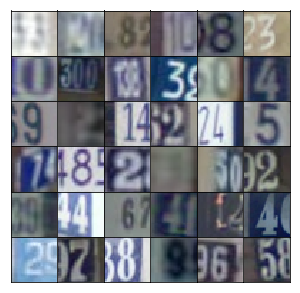

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [27]:
def conv_transpose_layer(prev_layer, layer_depth, kernel, is_training, alpha=0.01, strides = 2, normalize = True):
    conv_layer = tf.layers.conv2d_transpose(prev_layer,
                                            layer_depth,
                                            kernel_size=kernel,
                                            strides=strides,
                                            padding='same',
                                            activation=None)
    if normalize:
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_training)
    conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
    return conv_layer

In [30]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512, activation=None)
        
        x_reshaped = tf.reshape(x, (-1, 4, 4, 512))
        x_reshaped = tf.layers.batch_normalization(x_reshaped, training=training)
        # now 4x4x512
        
        conv1 = conv_layer(x_reshaped, 256, 5, training, alpha)
        # now 8x8x256
        conv2 = conv_layer(conv1, 128, 5, training, alpha)
        # now 16x16x128
        
        # Output layer, 32x32x3
        logits = conv_layer(conv2, output_dim, 5, training, alpha, normalize=False)
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [28]:
def conv_layer(prev_layer, layer_depth, kernel, is_training, alpha=0.01, strides = 2, normalize = True):
    conv_layer = tf.layers.conv2d(prev_layer,
                                            layer_depth,
                                            kernel_size=kernel,
                                            strides=strides,
                                            padding='same',
                                            activation=None)
    if normalize:
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_training)
    conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
    return conv_layer

In [20]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        l1 = conv_layer(x, 64, kernel=5, strides=2, is_training=True, normalize=False)
        # now 16x16x64
        l2 = conv_layer(l1, 128, kernel=5, strides=2, is_training=True)
        # now 8x8x128
        l3 = conv_layer(l2, 256, kernel=5, strides=2, is_training=True)
        # now 4x4x256
        flattened = tf.reshape(l3, (-1, 4*4*256))        
        
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [21]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [23]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [24]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [25]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [33]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.5620... Generator Loss: 0.8525
Epoch 1/25... Discriminator Loss: 0.4618... Generator Loss: 1.0036
Epoch 1/25... Discriminator Loss: 0.4012... Generator Loss: 1.1116
Epoch 1/25... Discriminator Loss: 0.2381... Generator Loss: 1.5630
Epoch 1/25... Discriminator Loss: 0.1331... Generator Loss: 2.1202
Epoch 1/25... Discriminator Loss: 0.0699... Generator Loss: 2.7290
Epoch 1/25... Discriminator Loss: 0.0781... Generator Loss: 2.6227
Epoch 1/25... Discriminator Loss: 0.0546... Generator Loss: 2.9757
Epoch 1/25... Discriminator Loss: 0.0488... Generator Loss: 3.1380
Epoch 1/25... Discriminator Loss: 0.0346... Generator Loss: 3.4850


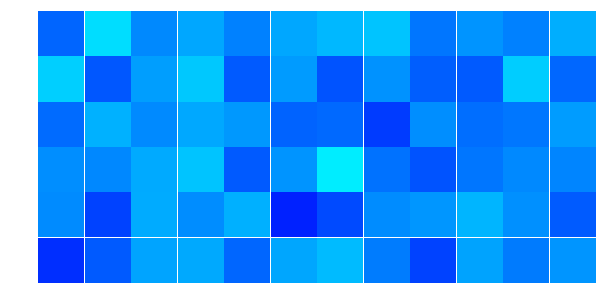

Epoch 1/25... Discriminator Loss: 0.0397... Generator Loss: 3.2990
Epoch 1/25... Discriminator Loss: 0.0440... Generator Loss: 3.2569
Epoch 1/25... Discriminator Loss: 0.0375... Generator Loss: 3.3359
Epoch 1/25... Discriminator Loss: 0.0324... Generator Loss: 3.4734
Epoch 1/25... Discriminator Loss: 0.0257... Generator Loss: 3.7866
Epoch 1/25... Discriminator Loss: 0.0227... Generator Loss: 3.8494
Epoch 1/25... Discriminator Loss: 0.0340... Generator Loss: 3.4475
Epoch 1/25... Discriminator Loss: 0.0192... Generator Loss: 4.0456
Epoch 1/25... Discriminator Loss: 0.0137... Generator Loss: 4.4628
Epoch 1/25... Discriminator Loss: 0.0116... Generator Loss: 4.6647


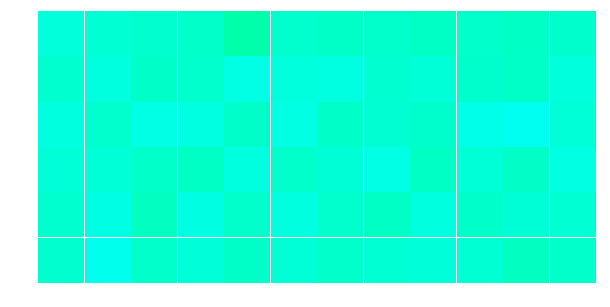

Epoch 1/25... Discriminator Loss: 0.0131... Generator Loss: 4.5079
Epoch 1/25... Discriminator Loss: 0.0076... Generator Loss: 5.0788
Epoch 1/25... Discriminator Loss: 0.0080... Generator Loss: 5.1652
Epoch 1/25... Discriminator Loss: 0.0178... Generator Loss: 4.2687
Epoch 1/25... Discriminator Loss: 0.0082... Generator Loss: 5.0160
Epoch 1/25... Discriminator Loss: 0.0130... Generator Loss: 4.5063
Epoch 1/25... Discriminator Loss: 0.0132... Generator Loss: 4.5076
Epoch 1/25... Discriminator Loss: 0.0065... Generator Loss: 5.1012
Epoch 1/25... Discriminator Loss: 0.0052... Generator Loss: 5.5450
Epoch 1/25... Discriminator Loss: 0.0055... Generator Loss: 5.5839


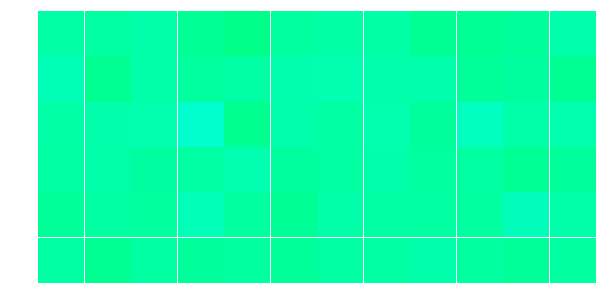

Epoch 1/25... Discriminator Loss: 0.0045... Generator Loss: 5.7156
Epoch 1/25... Discriminator Loss: 0.0088... Generator Loss: 4.8895
Epoch 1/25... Discriminator Loss: 0.0025... Generator Loss: 6.4449
Epoch 1/25... Discriminator Loss: 0.0040... Generator Loss: 5.8517
Epoch 1/25... Discriminator Loss: 0.0091... Generator Loss: 4.8458
Epoch 1/25... Discriminator Loss: 0.0033... Generator Loss: 6.0537
Epoch 1/25... Discriminator Loss: 0.0056... Generator Loss: 5.3204
Epoch 1/25... Discriminator Loss: 0.0016... Generator Loss: 6.6739
Epoch 1/25... Discriminator Loss: 0.0042... Generator Loss: 5.9173
Epoch 1/25... Discriminator Loss: 0.0078... Generator Loss: 5.0333


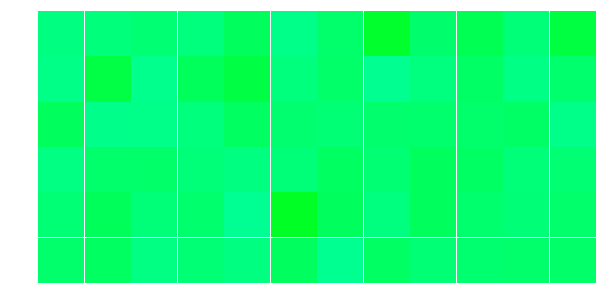

Epoch 1/25... Discriminator Loss: 0.0010... Generator Loss: 7.1123
Epoch 1/25... Discriminator Loss: 0.0045... Generator Loss: 5.5852
Epoch 1/25... Discriminator Loss: 0.0048... Generator Loss: 5.5495
Epoch 1/25... Discriminator Loss: 0.0040... Generator Loss: 6.4002
Epoch 1/25... Discriminator Loss: 0.0029... Generator Loss: 5.9710
Epoch 1/25... Discriminator Loss: 0.0015... Generator Loss: 6.6494
Epoch 1/25... Discriminator Loss: 0.0053... Generator Loss: 5.3112
Epoch 1/25... Discriminator Loss: 0.0026... Generator Loss: 6.3443
Epoch 1/25... Discriminator Loss: 0.0009... Generator Loss: 7.4612
Epoch 1/25... Discriminator Loss: 0.0077... Generator Loss: 5.1795


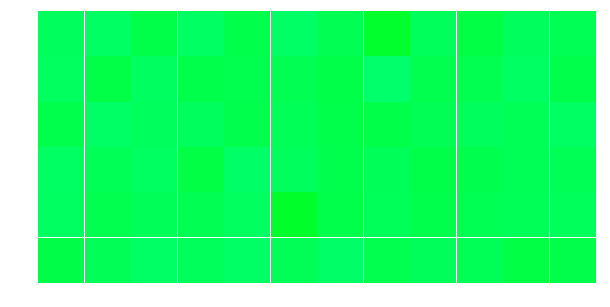

Epoch 1/25... Discriminator Loss: 0.0012... Generator Loss: 7.3814
Epoch 1/25... Discriminator Loss: 0.0016... Generator Loss: 6.7347
Epoch 1/25... Discriminator Loss: 0.0015... Generator Loss: 6.7230
Epoch 1/25... Discriminator Loss: 0.0115... Generator Loss: 4.6211
Epoch 1/25... Discriminator Loss: 0.0015... Generator Loss: 6.8811
Epoch 1/25... Discriminator Loss: 0.0018... Generator Loss: 6.5322
Epoch 1/25... Discriminator Loss: 0.0016... Generator Loss: 6.6957
Epoch 2/25... Discriminator Loss: 0.0084... Generator Loss: 4.9240
Epoch 2/25... Discriminator Loss: 0.0098... Generator Loss: 4.7505
Epoch 2/25... Discriminator Loss: 0.0009... Generator Loss: 7.3406


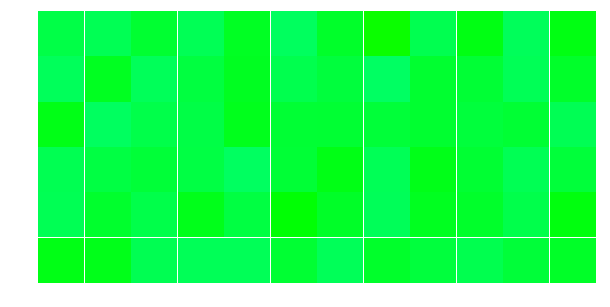

Epoch 2/25... Discriminator Loss: 0.0067... Generator Loss: 5.0534
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7076
Epoch 2/25... Discriminator Loss: 0.0016... Generator Loss: 6.7669
Epoch 2/25... Discriminator Loss: 0.0048... Generator Loss: 5.5203
Epoch 2/25... Discriminator Loss: 0.0006... Generator Loss: 7.7573
Epoch 2/25... Discriminator Loss: 0.0003... Generator Loss: 8.3259
Epoch 2/25... Discriminator Loss: 0.0021... Generator Loss: 6.6608
Epoch 2/25... Discriminator Loss: 0.0006... Generator Loss: 7.5940
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 9.7010
Epoch 2/25... Discriminator Loss: 0.0035... Generator Loss: 5.8775


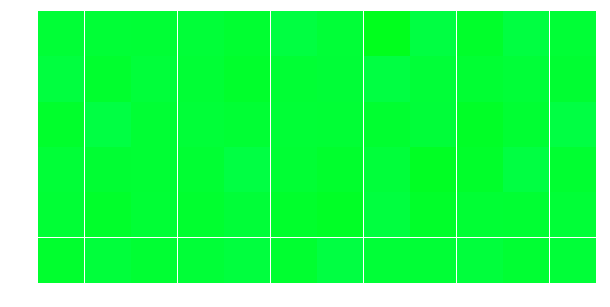

Epoch 2/25... Discriminator Loss: 0.0087... Generator Loss: 5.0747
Epoch 2/25... Discriminator Loss: 0.0027... Generator Loss: 6.1334
Epoch 2/25... Discriminator Loss: 0.0042... Generator Loss: 5.5998
Epoch 2/25... Discriminator Loss: 0.0031... Generator Loss: 5.9815
Epoch 2/25... Discriminator Loss: 0.0025... Generator Loss: 6.1276
Epoch 2/25... Discriminator Loss: 0.0013... Generator Loss: 7.1664
Epoch 2/25... Discriminator Loss: 0.0003... Generator Loss: 8.4964
Epoch 2/25... Discriminator Loss: 0.0016... Generator Loss: 6.8194
Epoch 2/25... Discriminator Loss: 0.0028... Generator Loss: 5.9850
Epoch 2/25... Discriminator Loss: 0.0008... Generator Loss: 8.3041


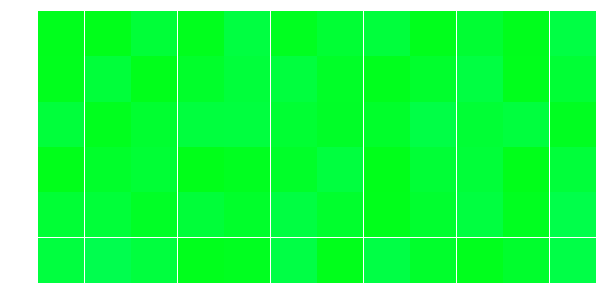

Epoch 2/25... Discriminator Loss: 0.0030... Generator Loss: 5.9351
Epoch 2/25... Discriminator Loss: 0.0010... Generator Loss: 7.2605
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 10.5797
Epoch 2/25... Discriminator Loss: 0.0056... Generator Loss: 5.5212
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 12.4117
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.6289
Epoch 2/25... Discriminator Loss: 0.0003... Generator Loss: 8.2730
Epoch 2/25... Discriminator Loss: 0.0029... Generator Loss: 6.4538
Epoch 2/25... Discriminator Loss: 0.0137... Generator Loss: 4.4381
Epoch 2/25... Discriminator Loss: 0.0028... Generator Loss: 6.2098


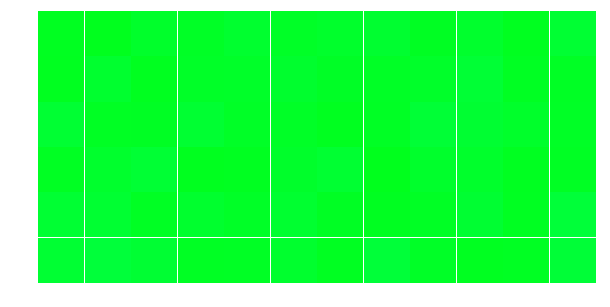

Epoch 2/25... Discriminator Loss: 0.0112... Generator Loss: 4.7770
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 8.9353
Epoch 2/25... Discriminator Loss: 0.0020... Generator Loss: 6.9416
Epoch 2/25... Discriminator Loss: 0.0005... Generator Loss: 8.1359
Epoch 2/25... Discriminator Loss: 0.0077... Generator Loss: 5.1154
Epoch 2/25... Discriminator Loss: 0.0009... Generator Loss: 7.1458
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 10.9052
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 9.2729
Epoch 2/25... Discriminator Loss: 0.0011... Generator Loss: 7.3566
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 9.7404


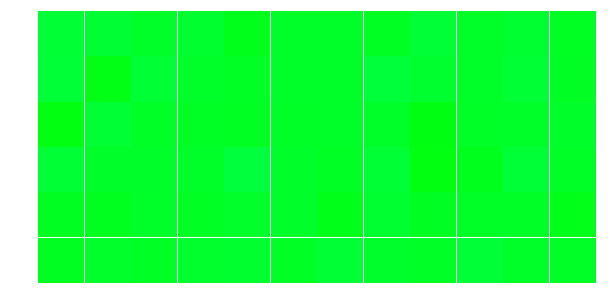

Epoch 2/25... Discriminator Loss: 0.0006... Generator Loss: 8.0014
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7660
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 10.9151
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 9.3428
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 8.9598
Epoch 2/25... Discriminator Loss: 0.0006... Generator Loss: 7.8220
Epoch 2/25... Discriminator Loss: 0.0033... Generator Loss: 6.0966
Epoch 2/25... Discriminator Loss: 0.0054... Generator Loss: 5.3572
Epoch 2/25... Discriminator Loss: 0.0064... Generator Loss: 5.2201
Epoch 2/25... Discriminator Loss: 0.0008... Generator Loss: 7.8769


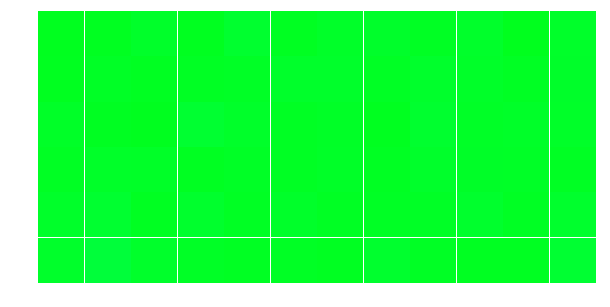

Epoch 2/25... Discriminator Loss: 0.0105... Generator Loss: 4.6901
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 14.7029
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 10.0534
Epoch 2/25... Discriminator Loss: 0.0003... Generator Loss: 9.3116
Epoch 3/25... Discriminator Loss: 0.0010... Generator Loss: 7.2964
Epoch 3/25... Discriminator Loss: 0.0038... Generator Loss: 5.6793
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 10.5433
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.5911
Epoch 3/25... Discriminator Loss: 0.0035... Generator Loss: 6.0408
Epoch 3/25... Discriminator Loss: 0.0006... Generator Loss: 8.0161


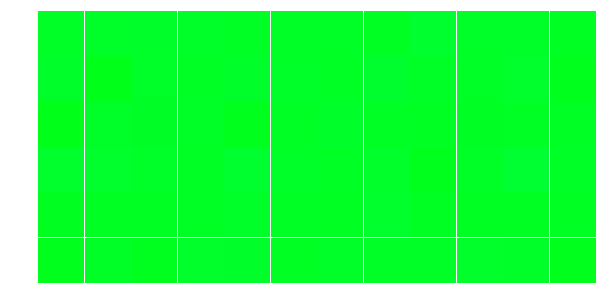

Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.1788
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 10.1692
Epoch 3/25... Discriminator Loss: 0.0088... Generator Loss: 4.9067
Epoch 3/25... Discriminator Loss: 0.0071... Generator Loss: 5.3871
Epoch 3/25... Discriminator Loss: 0.0007... Generator Loss: 8.1426
Epoch 3/25... Discriminator Loss: 0.0006... Generator Loss: 7.8084
Epoch 3/25... Discriminator Loss: 0.0011... Generator Loss: 7.2503
Epoch 3/25... Discriminator Loss: 0.0004... Generator Loss: 8.5740
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 11.1939
Epoch 3/25... Discriminator Loss: 0.0023... Generator Loss: 6.3386


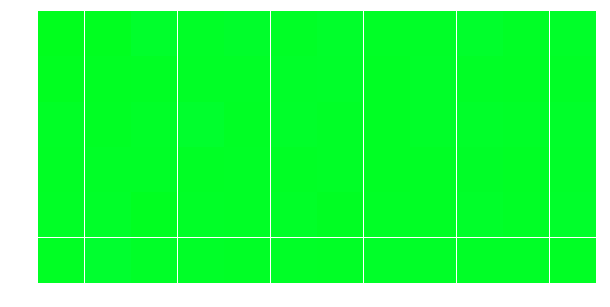

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 11.6215
Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.8719
Epoch 3/25... Discriminator Loss: 0.0064... Generator Loss: 5.6084
Epoch 3/25... Discriminator Loss: 0.0006... Generator Loss: 8.0692
Epoch 3/25... Discriminator Loss: 0.0016... Generator Loss: 6.6144
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.6059
Epoch 3/25... Discriminator Loss: 0.0012... Generator Loss: 7.0446
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.5308
Epoch 3/25... Discriminator Loss: 0.0019... Generator Loss: 6.4789
Epoch 3/25... Discriminator Loss: 0.0004... Generator Loss: 8.2597


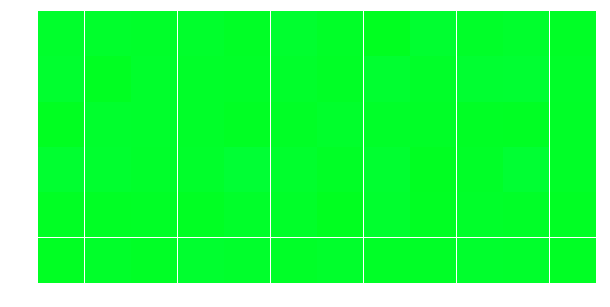

Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.2500
Epoch 3/25... Discriminator Loss: 0.0009... Generator Loss: 7.6042
Epoch 3/25... Discriminator Loss: 0.0040... Generator Loss: 5.6579
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.4593
Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.7022
Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.5335
Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.6738
Epoch 3/25... Discriminator Loss: 0.0006... Generator Loss: 8.2469
Epoch 3/25... Discriminator Loss: 0.0003... Generator Loss: 8.8518
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.9227


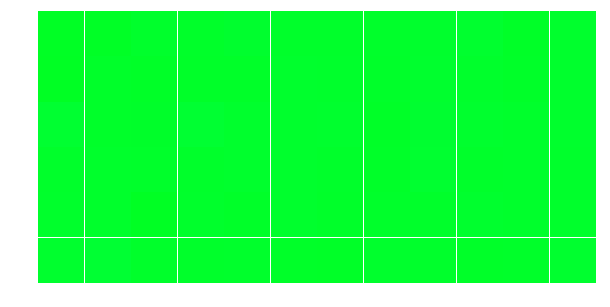

Epoch 3/25... Discriminator Loss: 0.0002... Generator Loss: 9.5551
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.7017
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.5829
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.5040
Epoch 3/25... Discriminator Loss: 0.0021... Generator Loss: 6.4260
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 13.2309
Epoch 3/25... Discriminator Loss: 0.0008... Generator Loss: 7.6793
Epoch 3/25... Discriminator Loss: 0.0004... Generator Loss: 8.0506
Epoch 3/25... Discriminator Loss: 0.0004... Generator Loss: 8.0916
Epoch 3/25... Discriminator Loss: 0.0007... Generator Loss: 7.8973


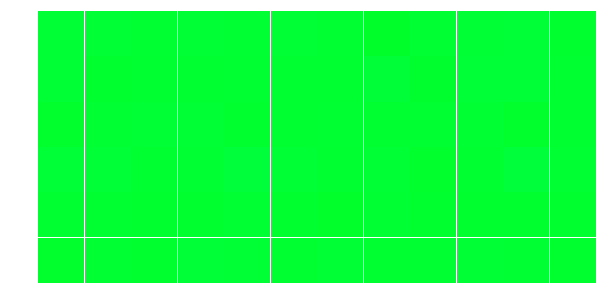

Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.7158
Epoch 3/25... Discriminator Loss: 0.0004... Generator Loss: 8.2339
Epoch 3/25... Discriminator Loss: 0.0027... Generator Loss: 6.1415
Epoch 3/25... Discriminator Loss: 0.0015... Generator Loss: 7.6201
Epoch 3/25... Discriminator Loss: 0.0002... Generator Loss: 8.8558
Epoch 3/25... Discriminator Loss: 0.0015... Generator Loss: 6.6801
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.8800
Epoch 3/25... Discriminator Loss: 0.0012... Generator Loss: 6.9215
Epoch 3/25... Discriminator Loss: 0.0014... Generator Loss: 6.6433
Epoch 3/25... Discriminator Loss: 0.0001... Generator Loss: 9.4334


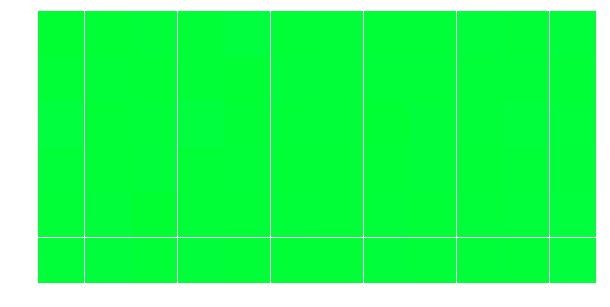

Epoch 3/25... Discriminator Loss: 0.0012... Generator Loss: 6.9234
Epoch 4/25... Discriminator Loss: 0.0006... Generator Loss: 7.9412
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 9.7602
Epoch 4/25... Discriminator Loss: 0.0008... Generator Loss: 7.4084
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.8347
Epoch 4/25... Discriminator Loss: 0.0007... Generator Loss: 7.7411
Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 8.7540
Epoch 4/25... Discriminator Loss: 0.0009... Generator Loss: 7.5321
Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 9.0397
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.1441


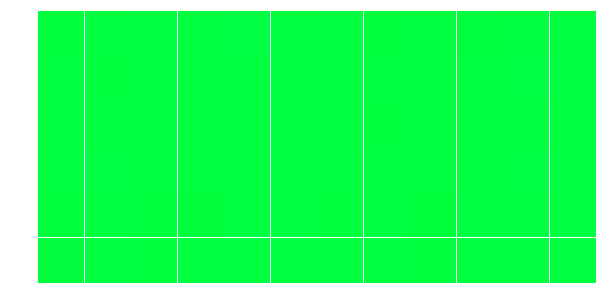

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 12.9942
Epoch 4/25... Discriminator Loss: 0.0015... Generator Loss: 6.6978
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.7530
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 9.0371
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.4459
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.8917
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.9430
Epoch 4/25... Discriminator Loss: 0.0011... Generator Loss: 7.3479
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 8.4206
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0223


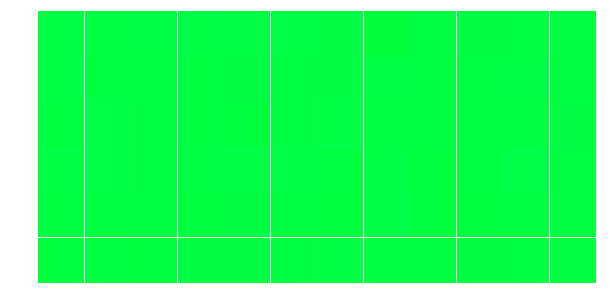

Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 8.4191
Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 9.1282
Epoch 4/25... Discriminator Loss: 0.0012... Generator Loss: 7.3309
Epoch 4/25... Discriminator Loss: 0.0043... Generator Loss: 5.6079
Epoch 4/25... Discriminator Loss: 0.0005... Generator Loss: 8.0770
Epoch 4/25... Discriminator Loss: 0.0009... Generator Loss: 7.3493
Epoch 4/25... Discriminator Loss: 0.0020... Generator Loss: 6.4055
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.5880
Epoch 4/25... Discriminator Loss: 0.0012... Generator Loss: 7.6559
Epoch 4/25... Discriminator Loss: 0.0019... Generator Loss: 6.3955


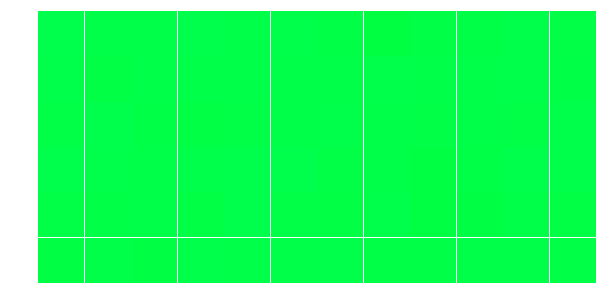

Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 8.5536
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.9223
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 14.2321
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.1008
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 12.9682
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 12.8918
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.7823
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 8.1927
Epoch 4/25... Discriminator Loss: 0.0010... Generator Loss: 7.0913
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 8.9192


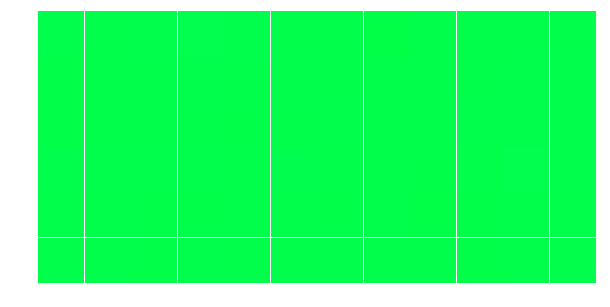

Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.6254
Epoch 4/25... Discriminator Loss: 0.0022... Generator Loss: 6.3261
Epoch 4/25... Discriminator Loss: 0.0005... Generator Loss: 7.9695
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.1266
Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 9.1429
Epoch 4/25... Discriminator Loss: 0.0008... Generator Loss: 7.5595
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 10.5589
Epoch 4/25... Discriminator Loss: 0.0028... Generator Loss: 6.3094
Epoch 4/25... Discriminator Loss: 0.0004... Generator Loss: 8.1401
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.3015


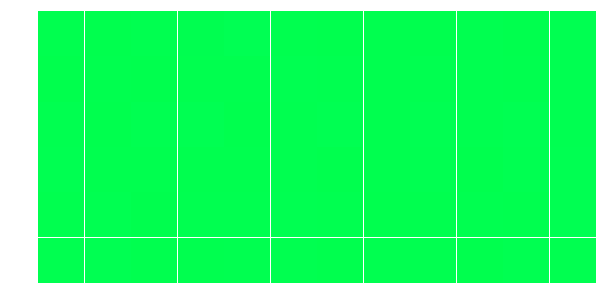

Epoch 4/25... Discriminator Loss: 0.0016... Generator Loss: 6.6086
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 9.4833
Epoch 4/25... Discriminator Loss: 0.0004... Generator Loss: 8.3211
Epoch 4/25... Discriminator Loss: 0.0003... Generator Loss: 8.6859
Epoch 4/25... Discriminator Loss: 0.0011... Generator Loss: 7.0832
Epoch 4/25... Discriminator Loss: 0.0001... Generator Loss: 9.1568
Epoch 4/25... Discriminator Loss: 0.0005... Generator Loss: 8.3205
Epoch 4/25... Discriminator Loss: 0.0002... Generator Loss: 9.1930
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4587
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 10.8372


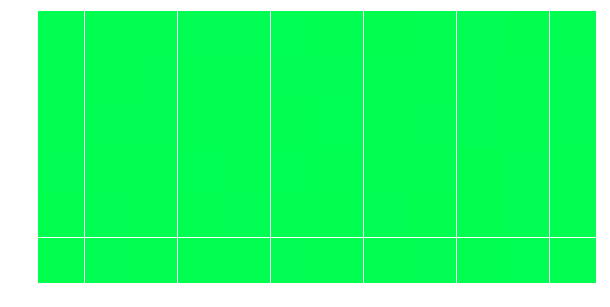

Epoch 5/25... Discriminator Loss: 0.0015... Generator Loss: 6.6529
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.3347
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.1988
Epoch 5/25... Discriminator Loss: 0.0008... Generator Loss: 7.3154
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.5657
Epoch 5/25... Discriminator Loss: 0.0008... Generator Loss: 7.6650
Epoch 5/25... Discriminator Loss: 0.0007... Generator Loss: 7.6655
Epoch 5/25... Discriminator Loss: 0.0007... Generator Loss: 7.3549
Epoch 5/25... Discriminator Loss: 0.0005... Generator Loss: 8.4629
Epoch 5/25... Discriminator Loss: 0.0016... Generator Loss: 6.5043


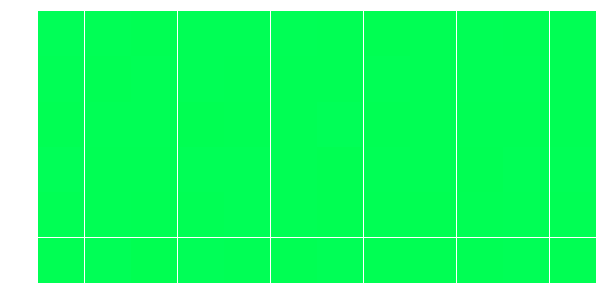

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.3380
Epoch 5/25... Discriminator Loss: 0.0011... Generator Loss: 7.1773
Epoch 5/25... Discriminator Loss: 0.0004... Generator Loss: 8.4418
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 11.4329
Epoch 5/25... Discriminator Loss: 0.0002... Generator Loss: 9.3354
Epoch 5/25... Discriminator Loss: 0.0012... Generator Loss: 6.8533
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 10.3195
Epoch 5/25... Discriminator Loss: 0.0012... Generator Loss: 7.0661
Epoch 5/25... Discriminator Loss: 0.0005... Generator Loss: 7.9624
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 9.8135


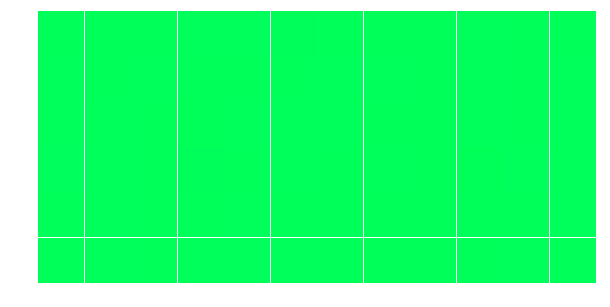

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 10.6696
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.6085
Epoch 5/25... Discriminator Loss: 0.0002... Generator Loss: 8.6091
Epoch 5/25... Discriminator Loss: 0.0027... Generator Loss: 6.0303
Epoch 5/25... Discriminator Loss: 0.0012... Generator Loss: 6.9484
Epoch 5/25... Discriminator Loss: 0.0023... Generator Loss: 6.3216
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 12.4671
Epoch 5/25... Discriminator Loss: 0.0007... Generator Loss: 7.4700
Epoch 5/25... Discriminator Loss: 0.0002... Generator Loss: 9.0138
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 9.8829


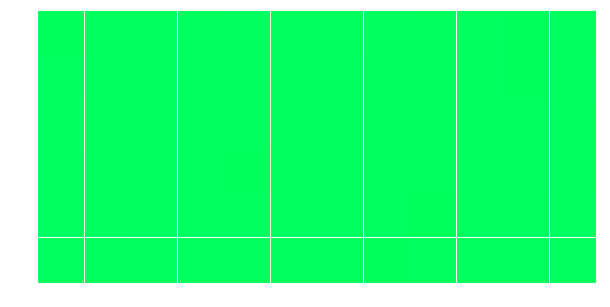

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 10.7087
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 9.9376
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 10.4261
Epoch 5/25... Discriminator Loss: 0.0009... Generator Loss: 7.2070
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.0526
Epoch 5/25... Discriminator Loss: 0.0007... Generator Loss: 7.8348
Epoch 5/25... Discriminator Loss: 0.0002... Generator Loss: 8.8606
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9017
Epoch 5/25... Discriminator Loss: 0.0008... Generator Loss: 7.4110
Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 10.9432


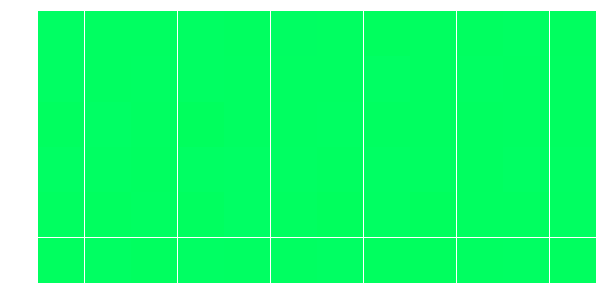

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.2830
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.2578
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 15.4435
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.1777
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.1985
Epoch 5/25... Discriminator Loss: 0.0002... Generator Loss: 8.8692
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.2164
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.1717
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.4469
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7492


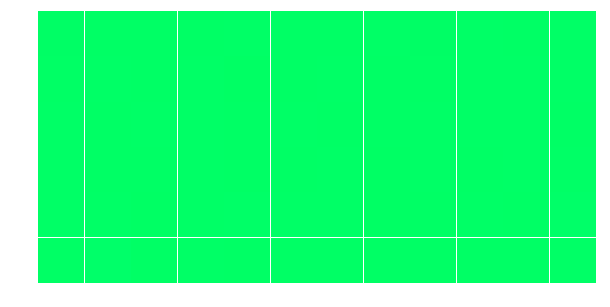

Epoch 5/25... Discriminator Loss: 0.0001... Generator Loss: 11.1113
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 9.0945
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.2206
Epoch 5/25... Discriminator Loss: 0.0003... Generator Loss: 8.7722
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7634
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 14.1244
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 14.8527
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.4676
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 11.5128
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.7127


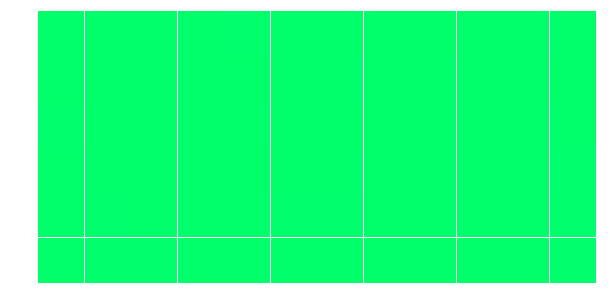

Epoch 6/25... Discriminator Loss: 0.0002... Generator Loss: 9.0246
Epoch 6/25... Discriminator Loss: 0.0002... Generator Loss: 9.1791
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.6275
Epoch 6/25... Discriminator Loss: 0.0007... Generator Loss: 7.4923
Epoch 6/25... Discriminator Loss: 0.0002... Generator Loss: 8.9431
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.7217
Epoch 6/25... Discriminator Loss: 0.0008... Generator Loss: 7.4400
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.4323
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.0445
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.6324


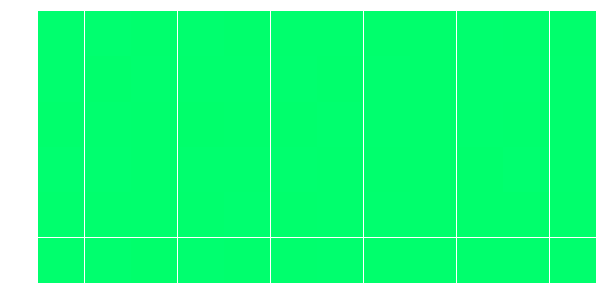

Epoch 6/25... Discriminator Loss: 0.0003... Generator Loss: 8.3491
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 11.5568
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 11.5712
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.8259
Epoch 6/25... Discriminator Loss: 0.0018... Generator Loss: 6.5232
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.6421
Epoch 6/25... Discriminator Loss: 0.0002... Generator Loss: 9.8480
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.9391
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 10.7262
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 10.7856


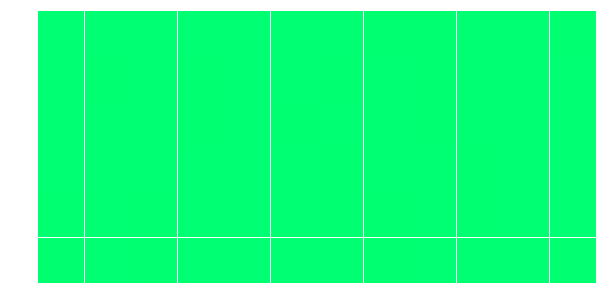

Epoch 6/25... Discriminator Loss: 0.0006... Generator Loss: 7.7397
Epoch 6/25... Discriminator Loss: 0.0009... Generator Loss: 7.3497
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 10.5018
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.1076
Epoch 6/25... Discriminator Loss: 0.0004... Generator Loss: 8.1590
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.6743
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.3405
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.4917
Epoch 6/25... Discriminator Loss: 0.0008... Generator Loss: 7.6937
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 10.7245


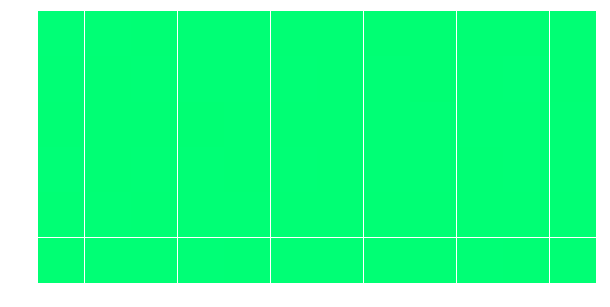

Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.8458
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.1305
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.1801
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.1902
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.4258
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 11.2409
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.6198
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.9192
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.8789
Epoch 6/25... Discriminator Loss: 0.0005... Generator Loss: 7.9108


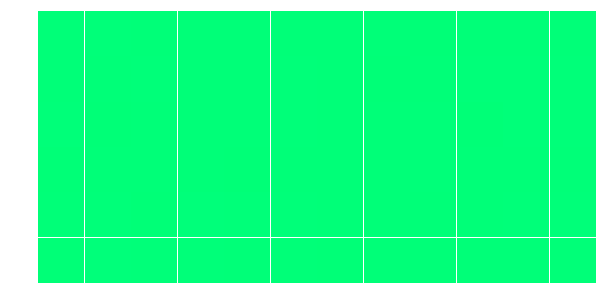

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 15.5221
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.5363
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 11.3057
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.1355
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.7466
Epoch 6/25... Discriminator Loss: 0.0006... Generator Loss: 7.6471
Epoch 6/25... Discriminator Loss: 0.0010... Generator Loss: 7.4657
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.1680
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 13.7609
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3794


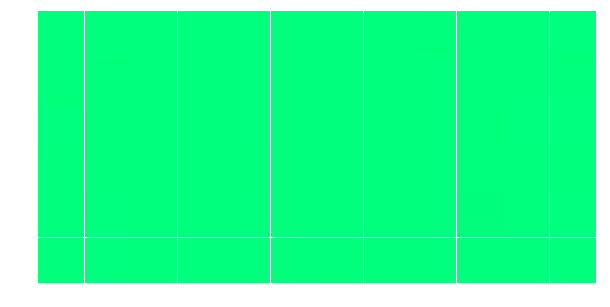

Epoch 6/25... Discriminator Loss: 0.0002... Generator Loss: 9.2257
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 10.7166
Epoch 6/25... Discriminator Loss: 0.0001... Generator Loss: 9.5665
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 9.3803
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 9.5479
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.0983
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.8564
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 8.9485
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 9.3359
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.5517


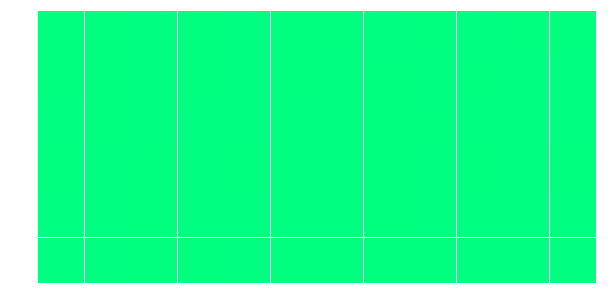

Epoch 7/25... Discriminator Loss: 0.0005... Generator Loss: 7.9714
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.3229
Epoch 7/25... Discriminator Loss: 0.0003... Generator Loss: 8.6272
Epoch 7/25... Discriminator Loss: 0.0011... Generator Loss: 7.0771
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 13.3165
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 9.3006
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.2686
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.6084
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 9.1442
Epoch 7/25... Discriminator Loss: 0.0004... Generator Loss: 8.0439


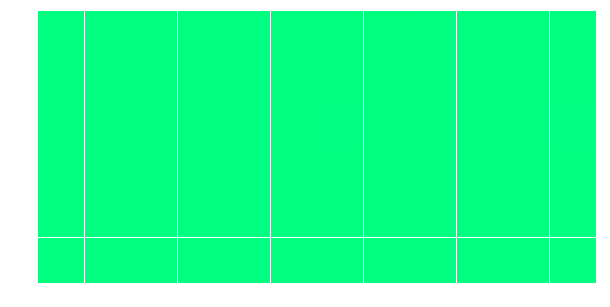

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 15.3443
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6552
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.5737
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.9882
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 13.4997
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 14.1184
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 8.4659
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.2509
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7234
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.0800


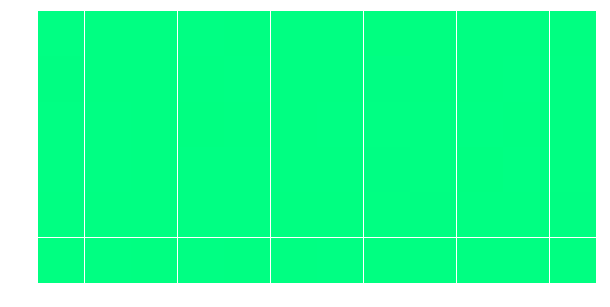

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 19.0411
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.0076
Epoch 7/25... Discriminator Loss: 0.0006... Generator Loss: 7.5965
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.2183
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.2544
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.9685
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.2127
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 8.8909
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.4646
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.5924


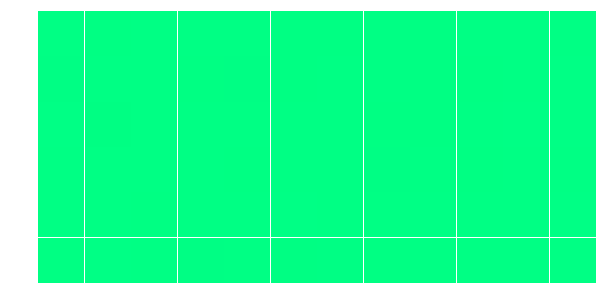

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.3148
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 8.6180
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 14.4794
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.0159
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.8844
Epoch 7/25... Discriminator Loss: 0.0003... Generator Loss: 8.6600
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 14.3994
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.1739
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 14.9360
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.6175


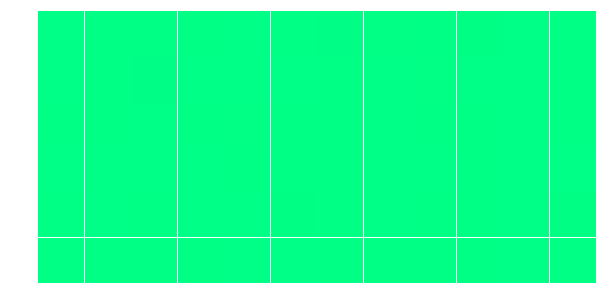

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 18.3011
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8062
Epoch 7/25... Discriminator Loss: 0.0002... Generator Loss: 8.7628
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8397
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 14.4955
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 9.6278
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 10.1966
Epoch 7/25... Discriminator Loss: 0.0001... Generator Loss: 10.7876
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7457
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 11.6053


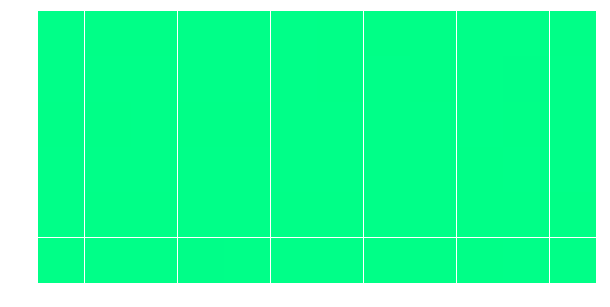

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 13.3045
Epoch 8/25... Discriminator Loss: 0.0004... Generator Loss: 8.1246
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9579
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.6719
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.8879
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.8743
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.6763
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.1894
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.2182
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.9065


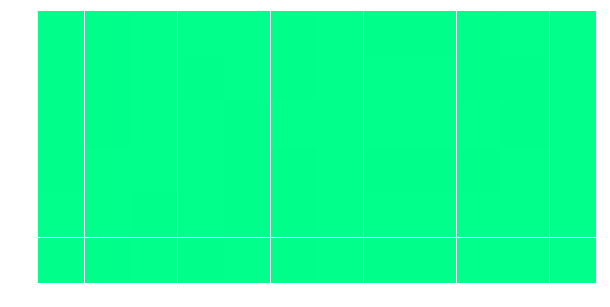

Epoch 8/25... Discriminator Loss: 0.0003... Generator Loss: 8.3347
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.8637
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.8694
Epoch 8/25... Discriminator Loss: 0.0008... Generator Loss: 7.2909
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.4026
Epoch 8/25... Discriminator Loss: 0.0004... Generator Loss: 8.3921
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 11.0884
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.7687
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.9062
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.7742


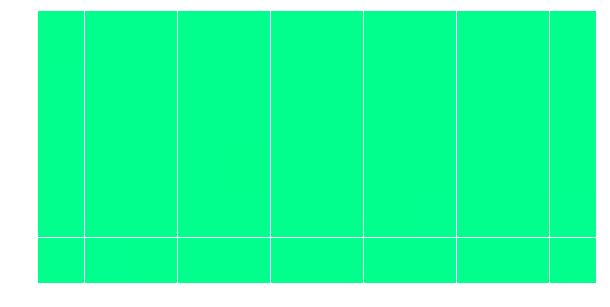

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.3052
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.1974
Epoch 8/25... Discriminator Loss: 0.0006... Generator Loss: 7.5929
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.2798
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.6871
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.6769
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.6958
Epoch 8/25... Discriminator Loss: 0.0002... Generator Loss: 8.6998
Epoch 8/25... Discriminator Loss: 0.0002... Generator Loss: 8.8723
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.9187


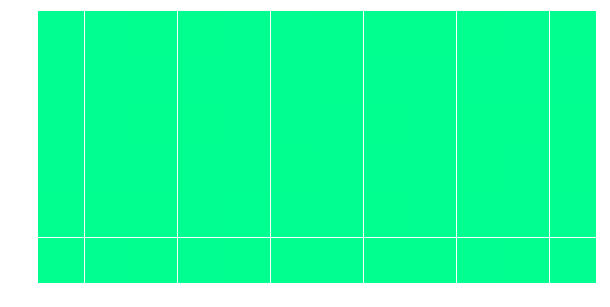

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 19.8219
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 10.0245
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.3734
Epoch 8/25... Discriminator Loss: 0.0002... Generator Loss: 8.7238
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.9454
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.6252
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.4790
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.5364
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 14.4706
Epoch 8/25... Discriminator Loss: 0.0002... Generator Loss: 8.8292


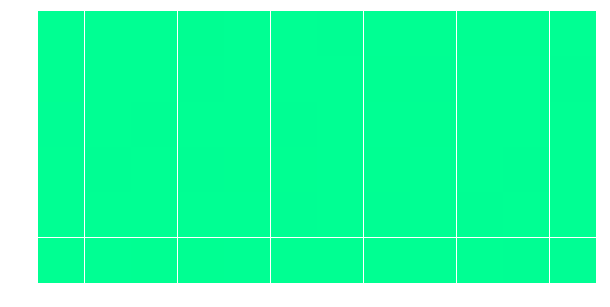

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.6312
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.9305
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.8485
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 14.2622
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.3642
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.0041
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 10.3050
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 9.2503
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.4723
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.4657


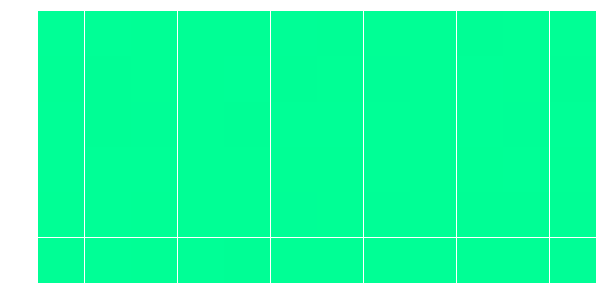

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.5429
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.8662
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 10.6577
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.8560
Epoch 8/25... Discriminator Loss: 0.0001... Generator Loss: 10.0365
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 11.3230
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8543
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.1407
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 10.6274
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.4848


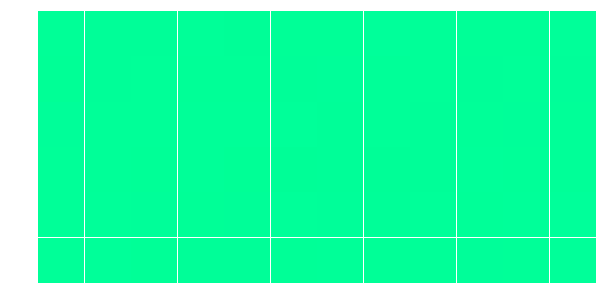

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.2985
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.0436
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 9.8936
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.0977
Epoch 9/25... Discriminator Loss: 0.0003... Generator Loss: 8.6650
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.3418
Epoch 9/25... Discriminator Loss: 0.0002... Generator Loss: 9.4954
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.4245
Epoch 9/25... Discriminator Loss: 0.0002... Generator Loss: 8.6456
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 8.8961


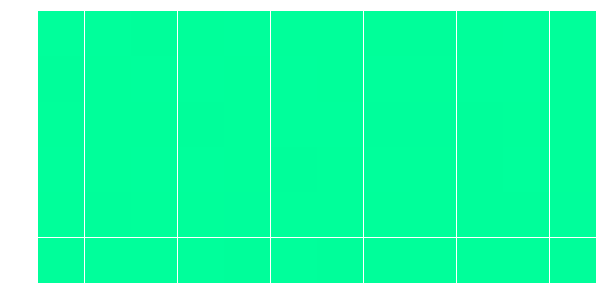

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.5615
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.1010
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.9926
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 14.5812
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 10.1137
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 9.7702
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 14.1736
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 10.3082
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.9003
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 10.4528


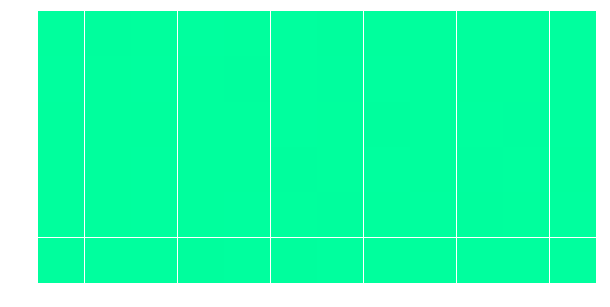

Epoch 9/25... Discriminator Loss: 0.0002... Generator Loss: 8.6371
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.9164
Epoch 9/25... Discriminator Loss: 0.0002... Generator Loss: 8.9011
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 14.3604
Epoch 9/25... Discriminator Loss: 0.0004... Generator Loss: 7.9192
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.3114
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.0201
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.9118
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.4245
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 15.2265


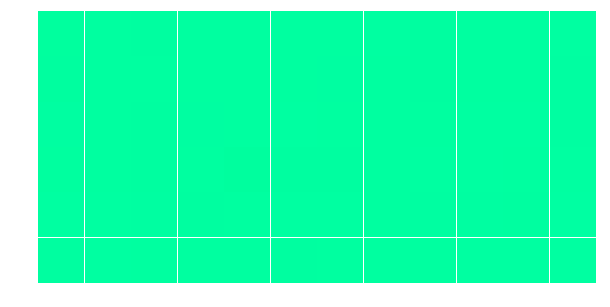

Epoch 9/25... Discriminator Loss: 0.0003... Generator Loss: 8.4777
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.2410
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.6140
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 14.2236
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.7181
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.7300
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.5681
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.1733
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.2623
Epoch 9/25... Discriminator Loss: 0.0001... Generator Loss: 10.2534


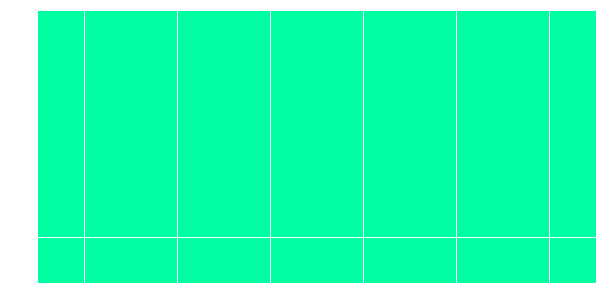

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.4651
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.6799
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.5654
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.8966
Epoch 9/25... Discriminator Loss: 0.0002... Generator Loss: 8.6340
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.1097
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.0618
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.5309
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 11.8194
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.1340


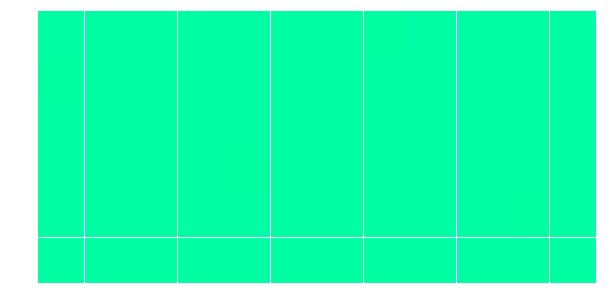

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.0002
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.4710
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 10.6769
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 14.0584
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 12.6242
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.5783
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.3907
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 14.0333
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.0564
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.8318


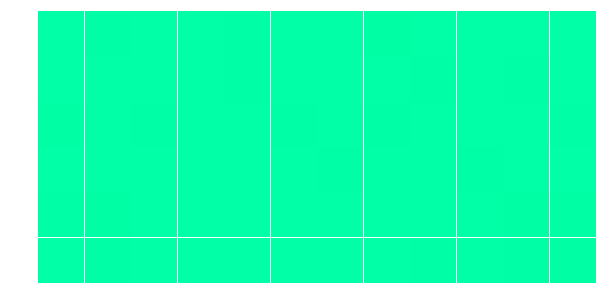

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.9497
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 14.7227
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.3305
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 15.2826
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.6626
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.2461
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.8168
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.6965
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.5842
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.8832


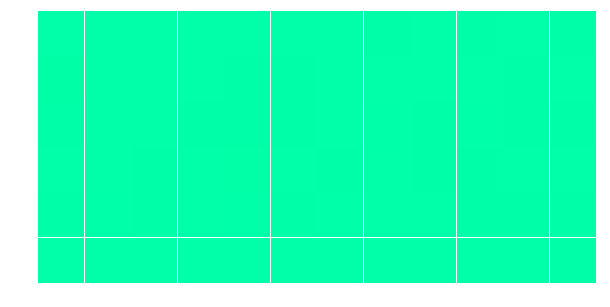

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.0262
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.0103
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.7405
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.8881
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.3245
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.5878
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.0412
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.7712
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 10.4588
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.0917


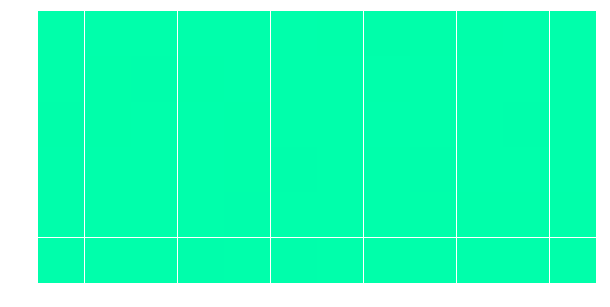

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.3074
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.5425
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.8620
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.7794
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.3416
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.2582
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.6917
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.0303
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.9659
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.2590


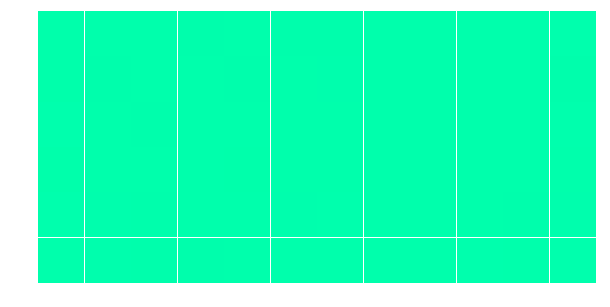

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.0172
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.0806
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.9718
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.3104
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.6638
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.7690
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 14.4412
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.9846
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.6029
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.6238


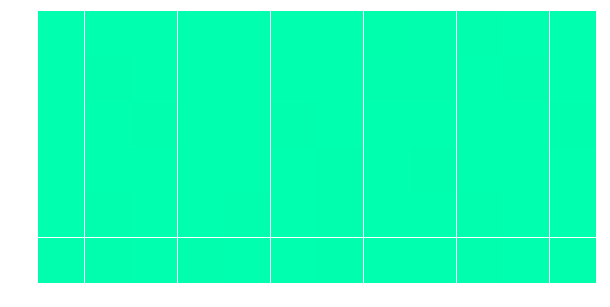

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.6233
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 10.1420
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.5163
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 14.3213
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.1071
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.9789
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.0663
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.0707
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 12.9673
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.9316


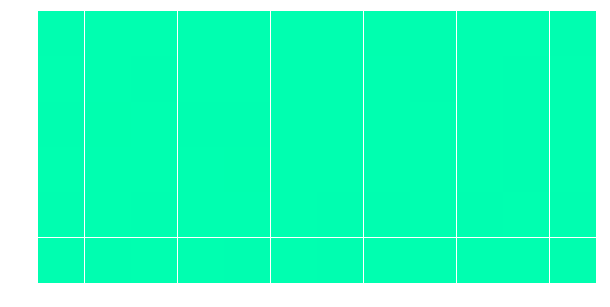

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.1684
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 11.2041
Epoch 10/25... Discriminator Loss: 0.0001... Generator Loss: 9.4973
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.8113
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.8162
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.5386
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.4609
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.4090
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.6333
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.4895


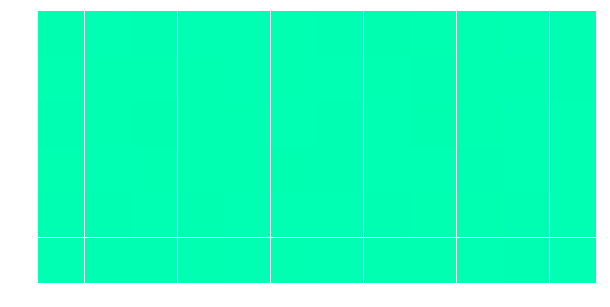

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.8103
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.0814
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.2996
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.6585
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 8.9972
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 10.1950
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.2924
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.1032
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9479
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.7880


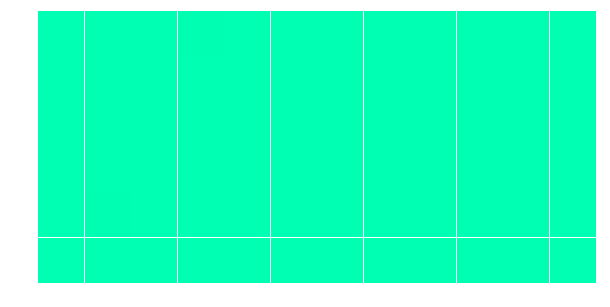

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.8706
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.8047
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.7421
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.8747
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.2005
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.2621
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.6084
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.0233
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.0418
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.6068


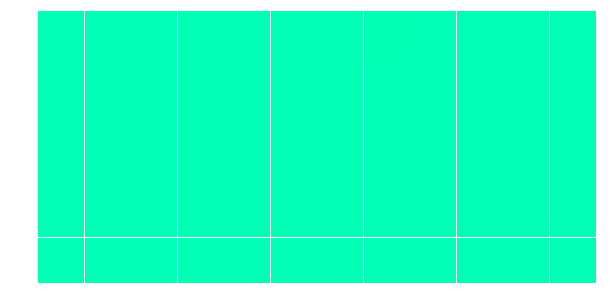

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.7039
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.8256
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.2337
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.9603
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.9653
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.6053
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.6315
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.7943
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.0019
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.3660


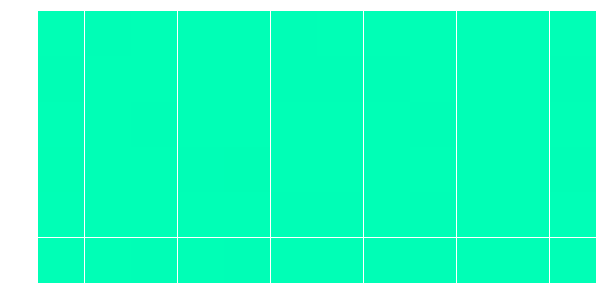

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.4138
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.3818
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.9480
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.6950
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.6588
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.6015
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.5731
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.2320
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.2714
Epoch 11/25... Discriminator Loss: 0.0001... Generator Loss: 9.7900


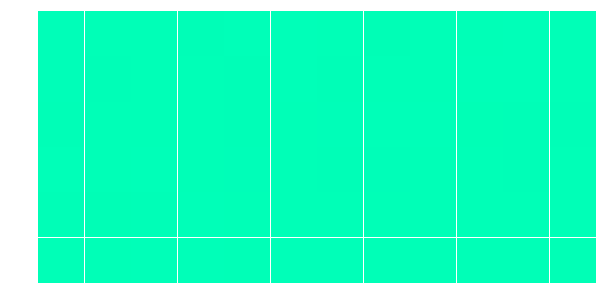

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 10.9939
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.7551
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.9450
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.2392
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.1280
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.8857
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.8682
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.9432
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 11.9575
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 12.1795


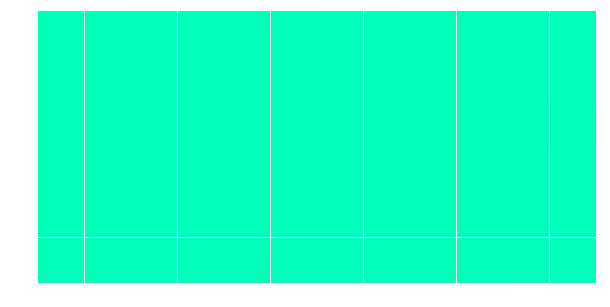

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.6659
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.1737
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.4475
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.6286
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.3648
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.3146
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.0298
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.8514
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.1387
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.1829


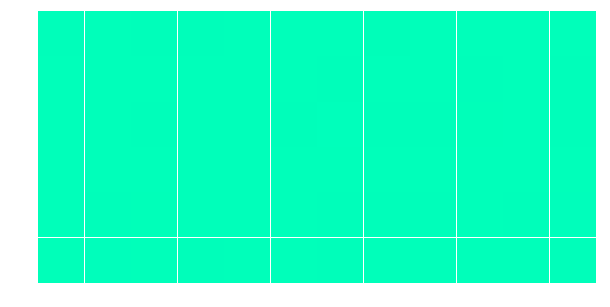

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.5378
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.1762
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.1837
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.0077
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.6697
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.2857
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.5658
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.7197
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.5922
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.8548


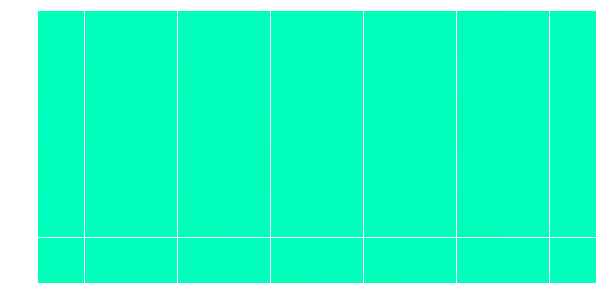

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.5021
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.9425
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.0828
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.6393
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.4915
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.3877
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.4262
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.6110
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.9087
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 15.3700


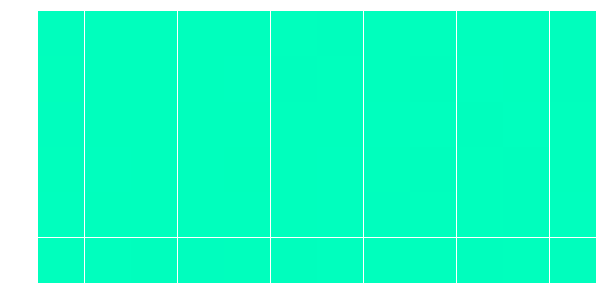

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3670
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.8076
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.1285
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.0852
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.5908
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.2143
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3853
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.4884
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.6351
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.0101


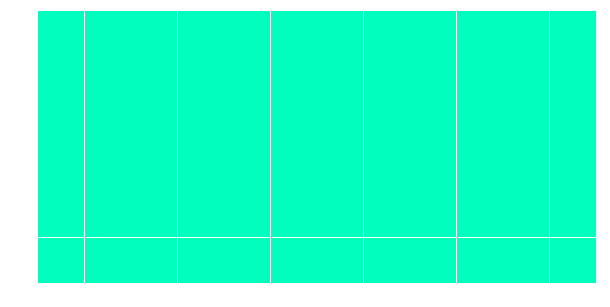

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.4071
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.6334
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.7850
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3943
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.4604
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.6998
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.3978
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.5509
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.9881
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.8662


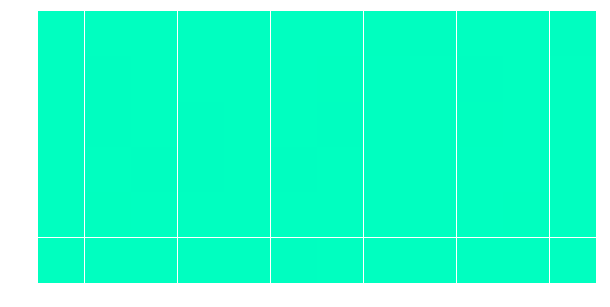

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.6213
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.1228
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 11.6941
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.5622
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 10.8978
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 13.1696
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 12.6233
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.9480
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.5745
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.1593


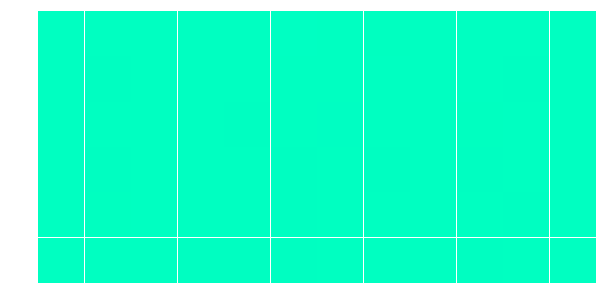

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.3514
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 10.8159
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 10.6889
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.0301
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.4860
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.6989
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.8387
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.1679
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.1644
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.5281


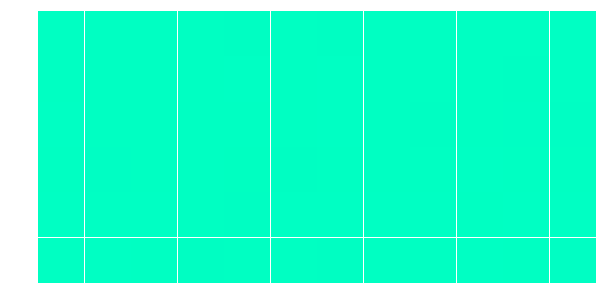

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.5469
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.6253
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.6625
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.0462
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.6259
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.9125
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.9285
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.4657
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.1376
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.8067


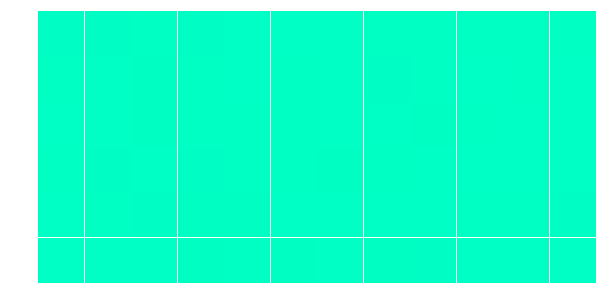

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.0141
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.6726
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.4853
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.3615
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.8346
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.1030
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.1899
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.2154
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.3321
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.2698


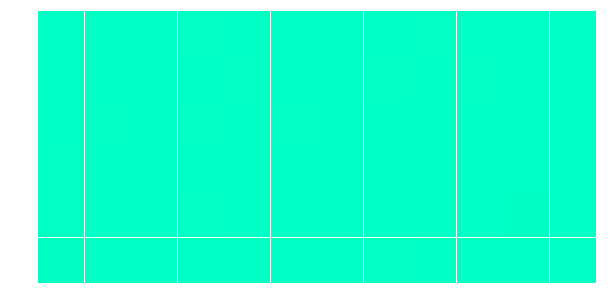

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.2101
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.2055
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.9206
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.1736
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.5572
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.9486
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.9009
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.9919
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.1990
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.2302


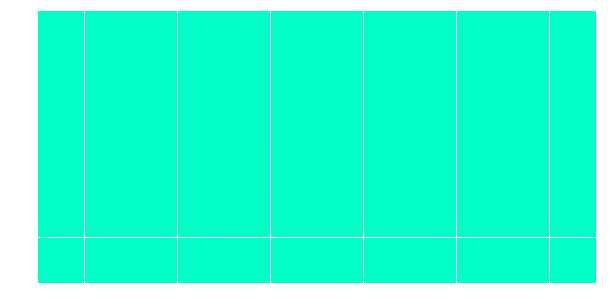

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.4360
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.2400
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.6679
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.7917
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 13.3271
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.4175
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.5282
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.4326
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.6776
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.9312


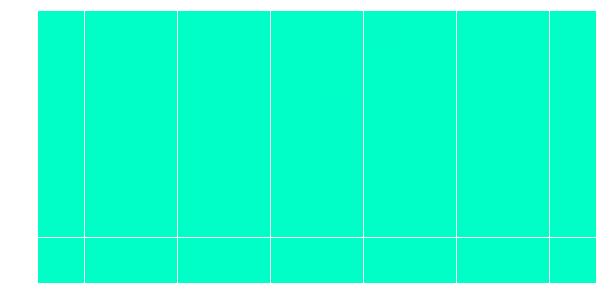

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.0386
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.3308
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 12.3592
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 11.5822
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6610
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.7823
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.8040
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 10.8902
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6245
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.3551


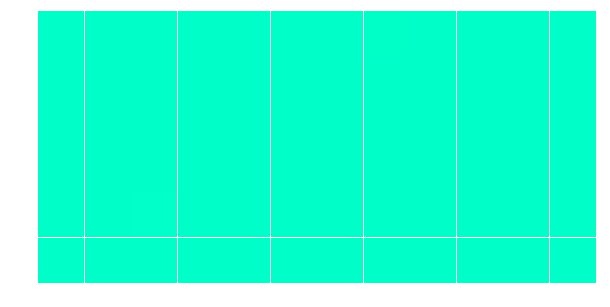

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.7424
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.4346
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.2297
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.1544
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 10.6047
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.3156
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.0772
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.1381
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.4448
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.7512


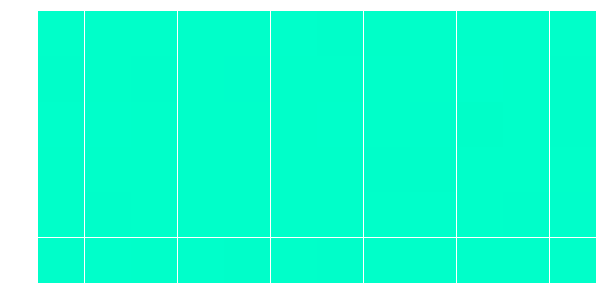

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.3149
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6455
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.2048
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.8979
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.4015
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.2505
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.8528
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.7715
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.4824
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.5482


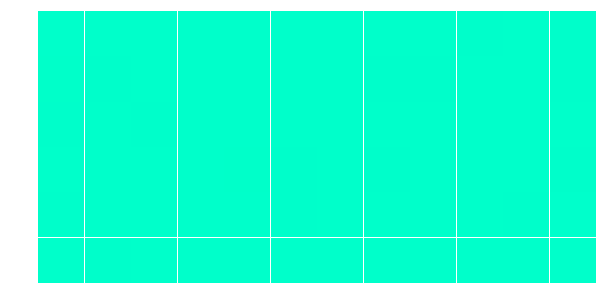

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6947
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6284
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.5315
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.1986
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.4481
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.5019
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.8404
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.3468
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6454
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.2640


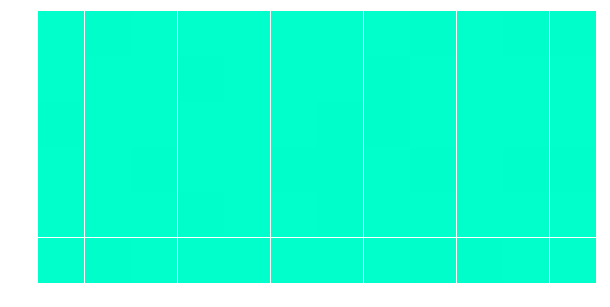

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.5389
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.2888
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.0498
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6205
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.4118
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.7597
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.3147
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.6201
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.7769
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.4975


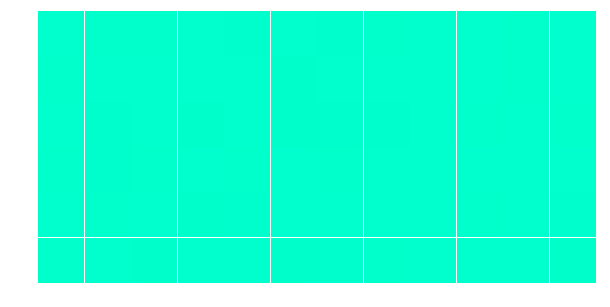

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.0740
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.6191
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.1092
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.3370
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.0858
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.3355
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.4224
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.2451
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.2938
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 13.9208


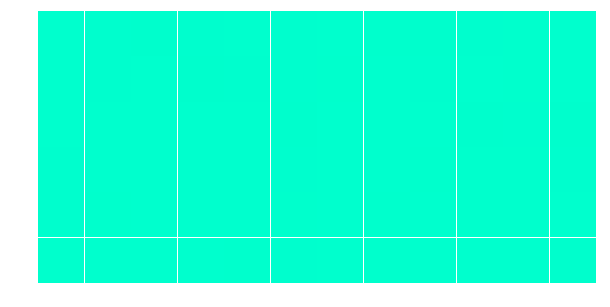

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 12.2525
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 11.5564
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.1837
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.6245
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.4681
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.9369
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.8424
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.9315
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.1247
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 14.4218


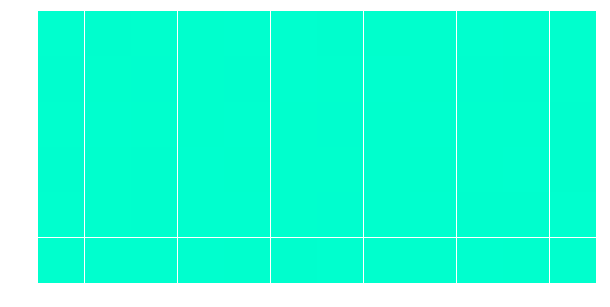

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4485
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4724
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.1116
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4515
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.0297
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.4753
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4344
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.7747
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.2207
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4277


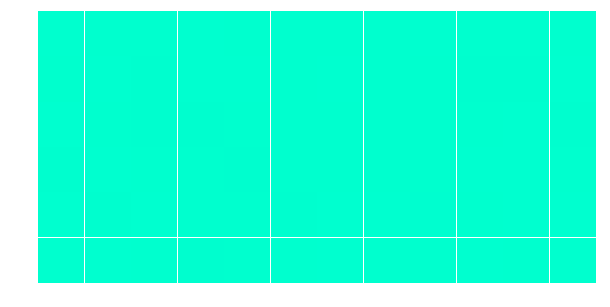

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.9526
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.4487
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.3542
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.3532
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.4894
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.2804
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.8018
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0747
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.0826
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.2132


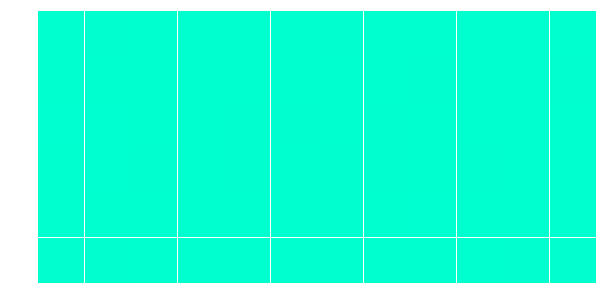

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.4318
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.2655
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.3783
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.8441
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.3952
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.9165
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.8070
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0581
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0767
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.7313


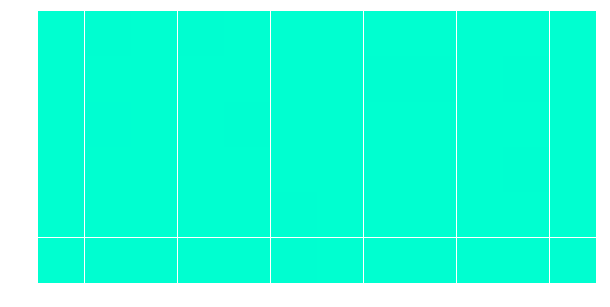

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.9584
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.7292
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.7203
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.0617
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4802
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0776
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0823
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.7238
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.4989
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 11.8088


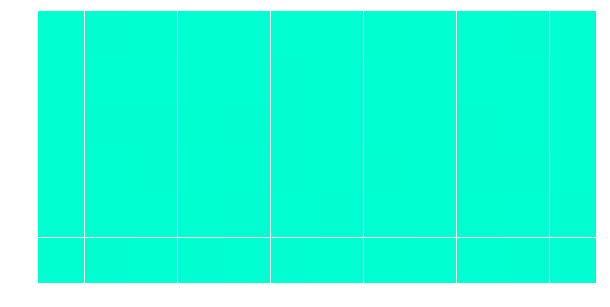

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4598
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.7906
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.4299
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.5109
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.1343
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.2301
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 13.0763
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.2772
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 12.5846
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 13.4231


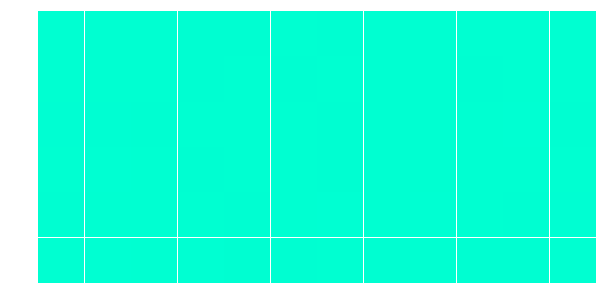

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 13.2912
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.5207
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2473
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4355
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.5935
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.6209
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.6714
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.6902
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.7113
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3162


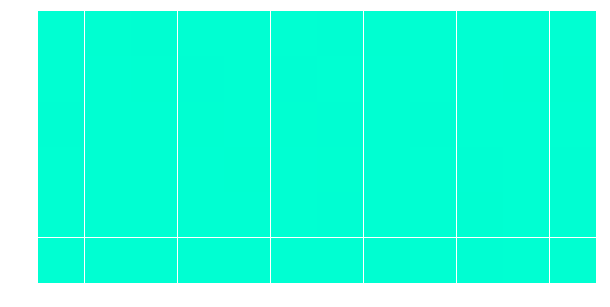

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.7685
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.7946
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.8065
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.8758
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.8678
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.9062
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.9055
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.9370
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3558
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.9836


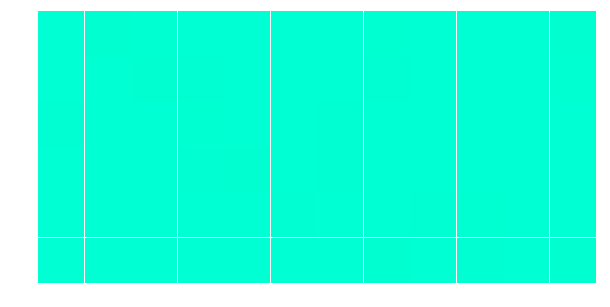

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 11.9829
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.0195
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.0334
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.0504
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.0858
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.0866
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.1241
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.1328
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.1616
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.1853


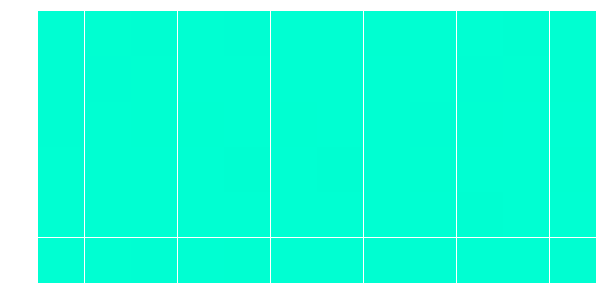

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2209
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2322
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2373
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2571
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2686
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2981
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.2983
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3572
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3449
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3501


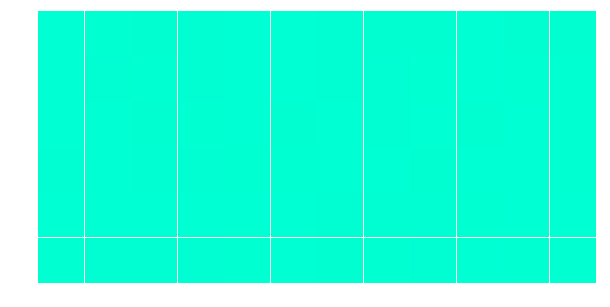

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.3748
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4066
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4012
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4219
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4587
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4851
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4948
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.4897
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 12.7385
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 16.8899


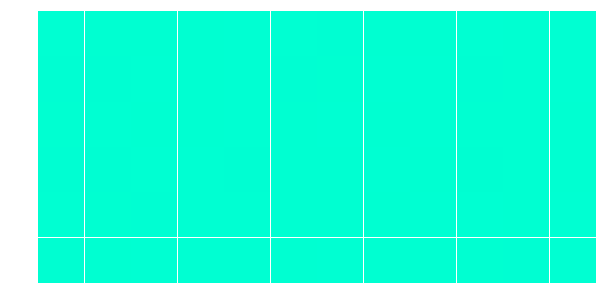

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.0853
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8124
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6024
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 14.6874
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 14.7632
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.1166
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.9636
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.0365
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.0364
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.4800


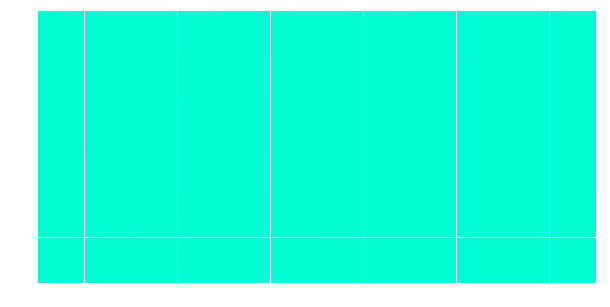

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.4495
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.9361
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.3319
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.8624
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.5786
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.6132
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.5869
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.3160
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.5173
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.9392


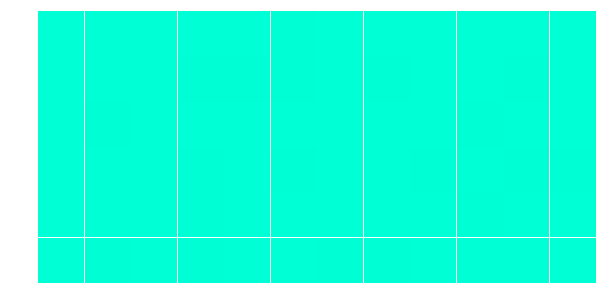

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.1674
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.6521
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7472
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.6757
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.6858
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7257
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7268
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7561
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7477
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7808


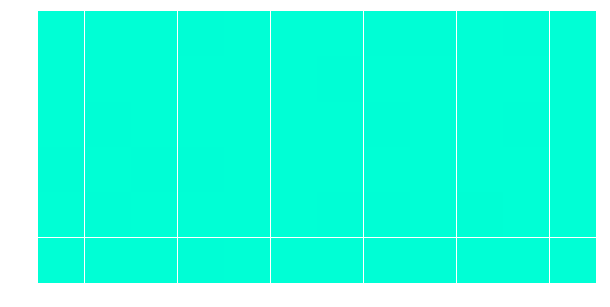

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7882
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.7972
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.9753
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.5847
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.8369
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.7288
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.2094
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.8437
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.4870
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.4882


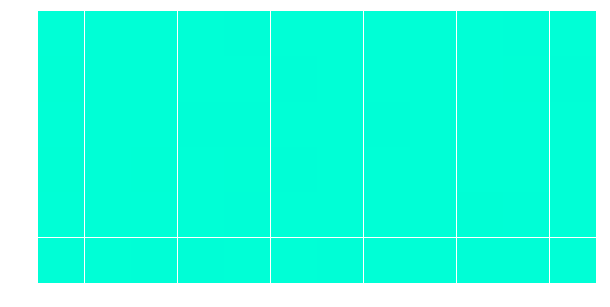

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.4938
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.6820
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.8565
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0403
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.9897
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.9948
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.9110
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.9178
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.7624
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.4588


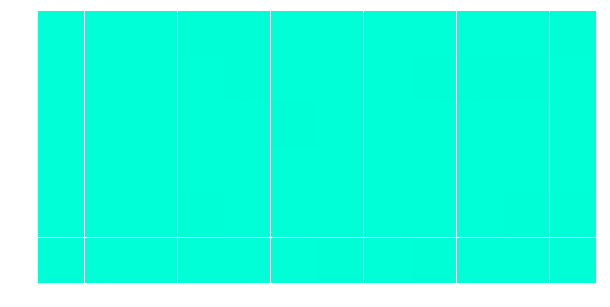

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 14.1986
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 12.9724
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0687
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.9623
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.2898
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.4236
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0068
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0085
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0232
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0346


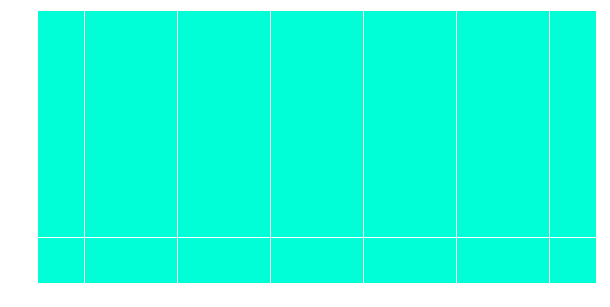

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0372
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.1190
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0813
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 13.0746
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1128
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1200
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1196
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1319
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1417
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1635


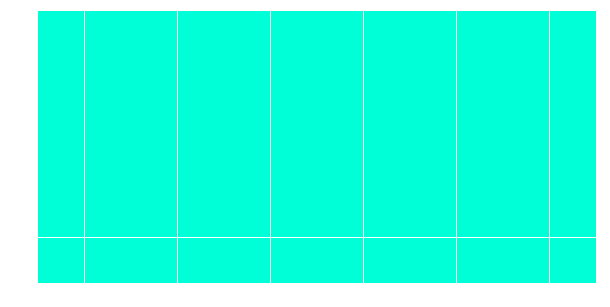

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1700
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1956
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.1898
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2201
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2303
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2357
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2355
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2615
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2549
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2787


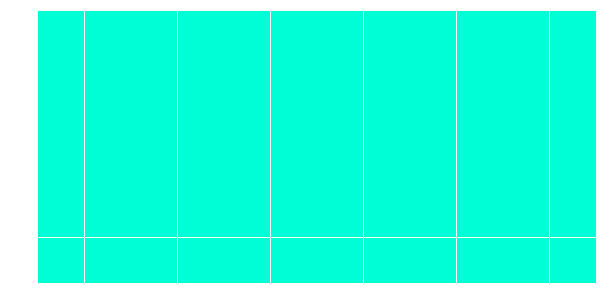

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.2869
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.3019
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.3161
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.3191
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.3345
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.8821
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 14.9278
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.3234
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.3468
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.0667


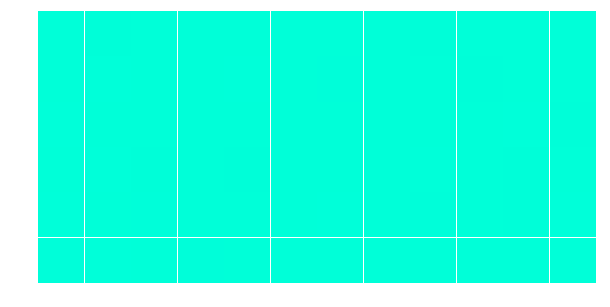

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 14.9050
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.1351
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.7950
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 14.4211
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.1161
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.9613
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 14.3462
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.5188
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.3886
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4048


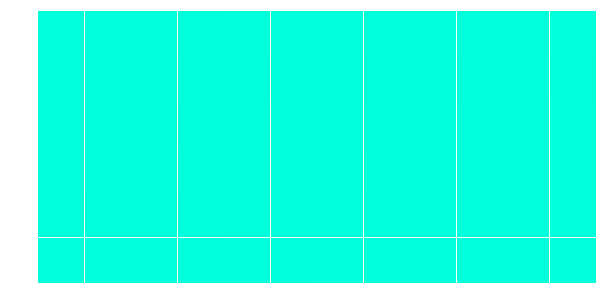

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4100
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4300
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4308
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 15.0867
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5447
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4544
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4636
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.4669
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5627
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5073


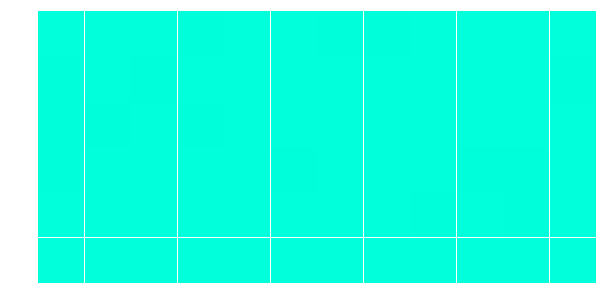

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5166
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5278
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5402
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5338
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5504
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5685
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5625
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5896
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5873
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.5956


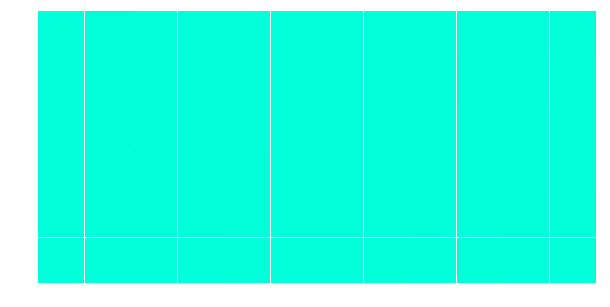

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 13.6207
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.6280
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.1498
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.3659
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 17.8910
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.4028
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.4009
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.8867
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.0630
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.6575


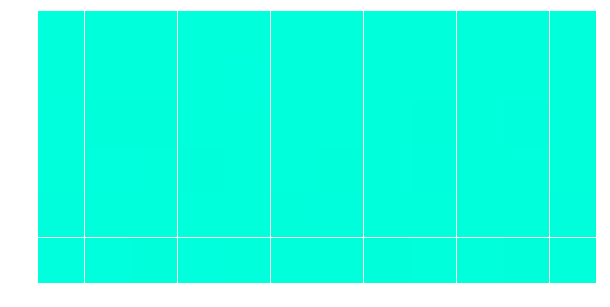

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.9982
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.4170
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7116
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.6718
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7315
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.2074
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.3618
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.0297
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7143
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7286


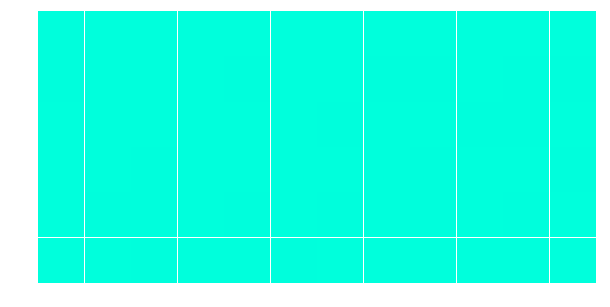

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7284
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7319
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7417
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7498
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7674
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7821
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7841
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.7751
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8263
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8152


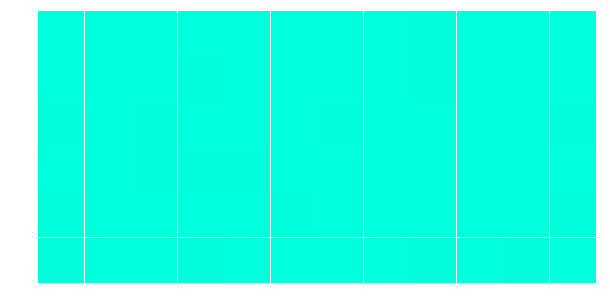

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8259
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8343
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8614
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8509
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8716
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8759
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.8980
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 17.0168
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 17.4434
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 17.4052


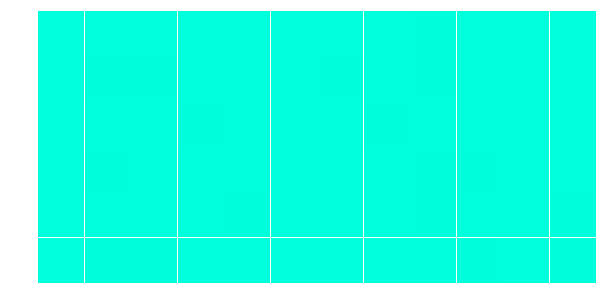

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.8990
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5280
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.1333
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.2180
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.4448
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9152
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9225
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9173
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9589
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9652


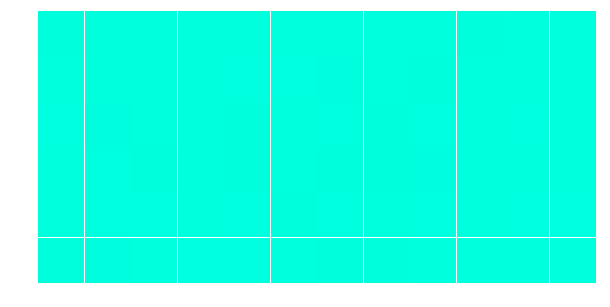

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9671
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 13.9653
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.0035
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.1595
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 15.4149
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.3408
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.0081
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 14.0155
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0128
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0304


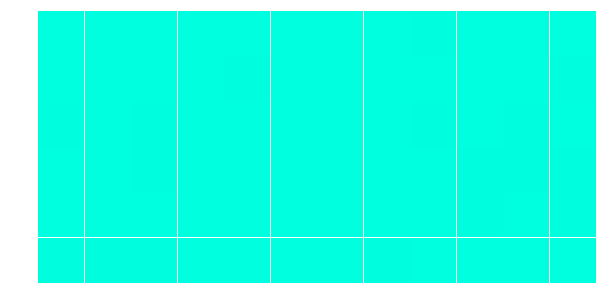

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0458
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0582
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0606
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0687
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0797
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.0846
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1045
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1083
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1185
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1290


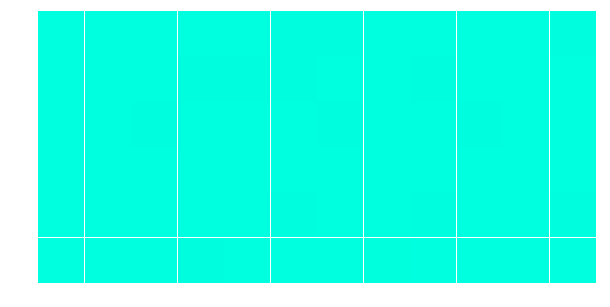

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1435
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1536
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1336
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1778
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1629
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1585
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1746
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.1958
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.8708
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.3124


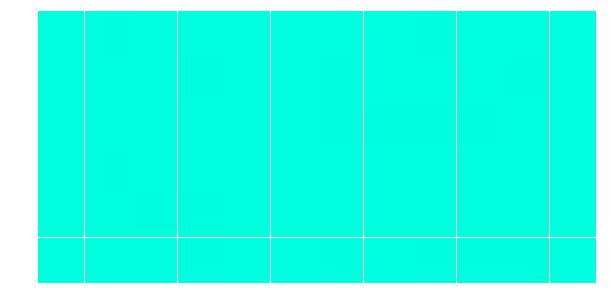

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 18.2243
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.4379
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.7054
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 15.5426
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.3278
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.3374
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3296
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2210
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2379
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2413


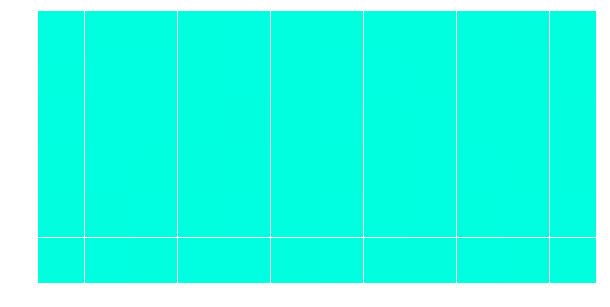

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2381
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2493
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2646
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2701
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.2867
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3050
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3139
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3069
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3114
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3303


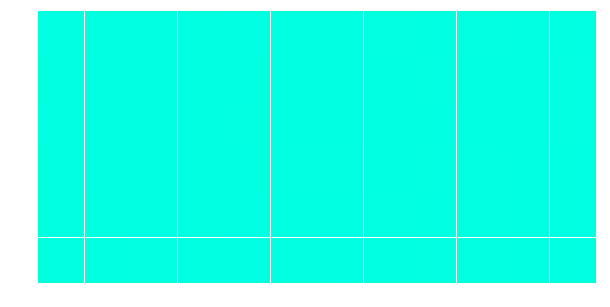

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3303
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3497
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3660
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3689
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3573
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3833
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.3793
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4017
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4241
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4262


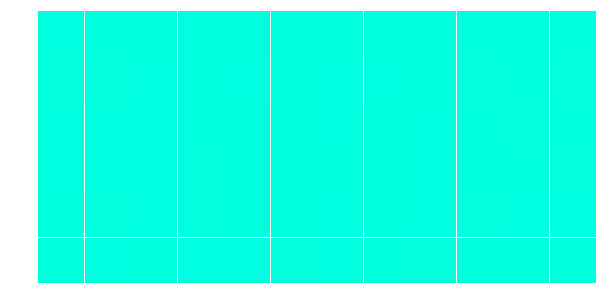

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4200
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4322
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4404
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4330
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4477
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 14.4462
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.4569
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.4951
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.4948
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.4924


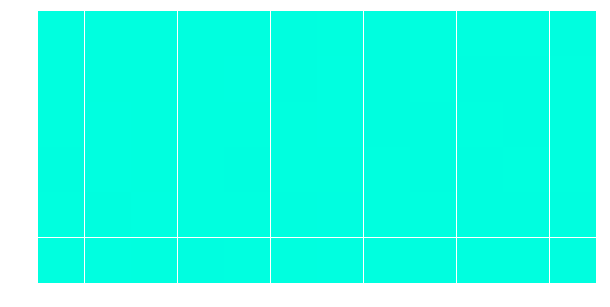

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5112
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5093
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5257
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5354
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5279
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6354
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 18.9866
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.1387
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.2961
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 16.2526


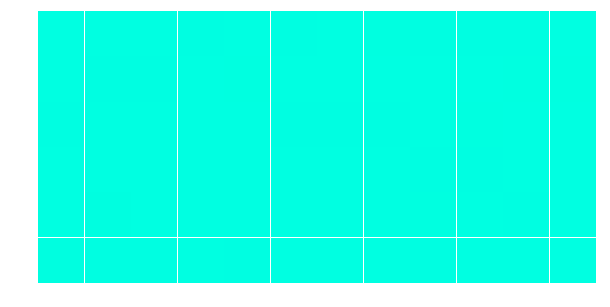

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3450
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 16.5945
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1460
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 23.4825
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.7306
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.6622
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.5434
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6084
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.5910
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6307


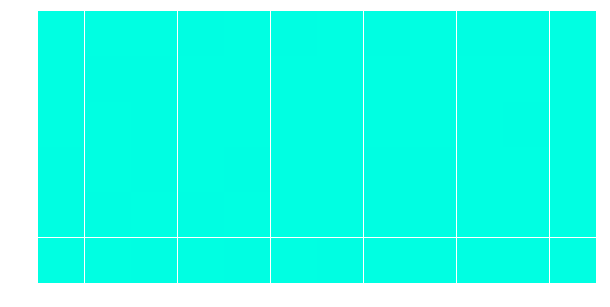

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6120
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6245
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6218
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.5621
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6674
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6268
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7370
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6829
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6523
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6678


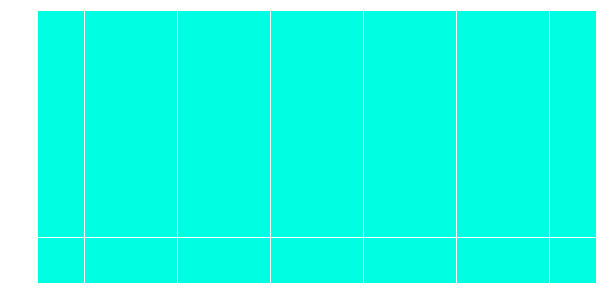

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6787
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6755
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7021
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7068
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.6973
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7351
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7057
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7385
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7382
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7325


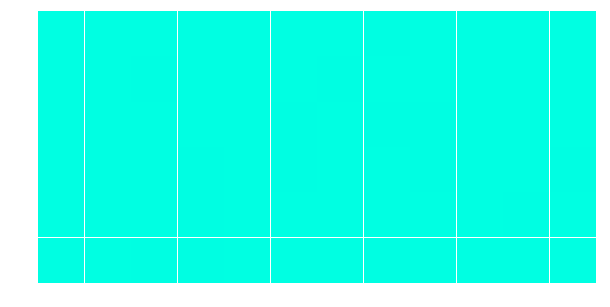

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7501
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7437
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7649
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7583
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.7917
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.3948
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 16.8857
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 16.3746
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2812
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 15.3412


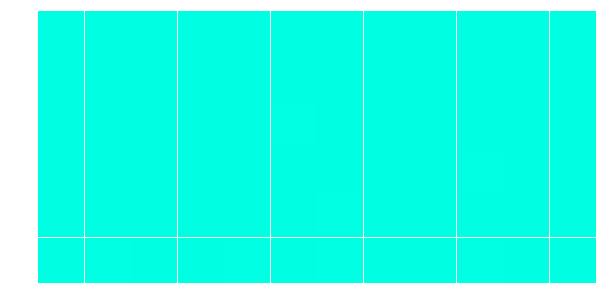

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.8080
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.8035
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 14.8221
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8082
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8319
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.6431
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 16.5236
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9450
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 16.9354
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9385


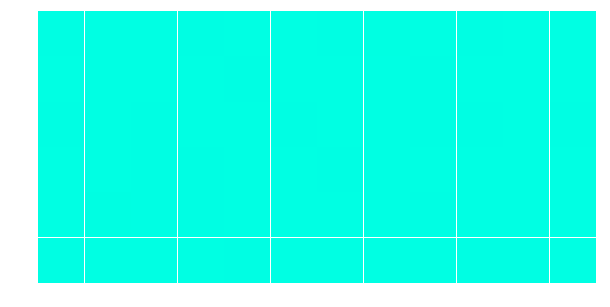

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1834
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8657
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8684
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8982
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8884
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.8985
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9161
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0145
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 16.0640
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9985


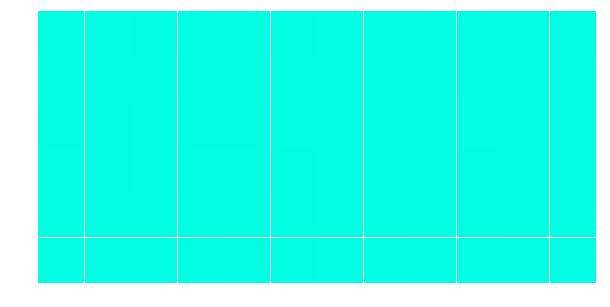

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9591
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9329
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9325
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9611
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9446
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9648
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9648
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9785
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 14.9862
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0051


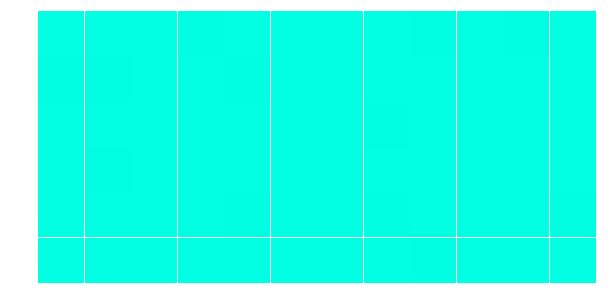

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0024
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0089
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0034
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0073
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0317
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0771
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0434
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0483
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0626
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0822


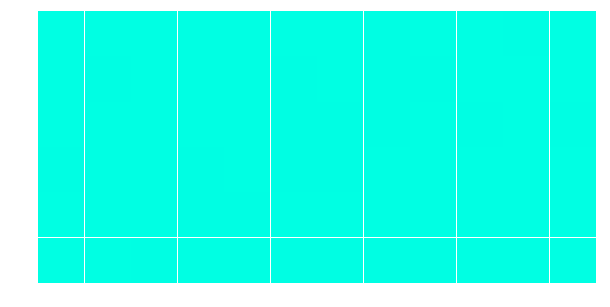

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0767
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0505
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0863
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0929
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.0999
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1178
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1300
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1216
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1306
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1419


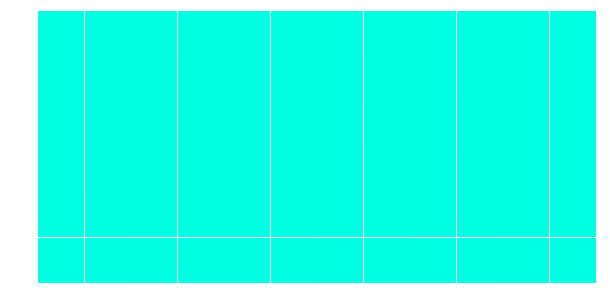

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1426
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1528
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1619
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1667
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1823
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1826
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1805
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1992
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.2125
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 15.1973


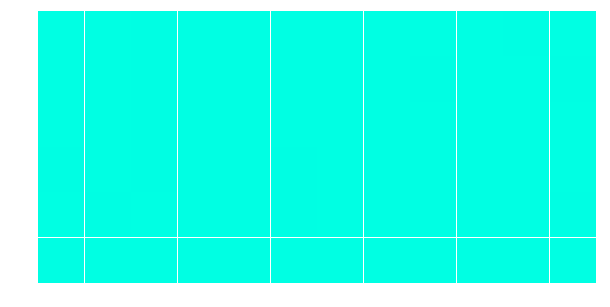

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2158
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2258
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 20.5767
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 18.9068
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 18.8743
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.4856
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.1251
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.5588
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.3169
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.9393


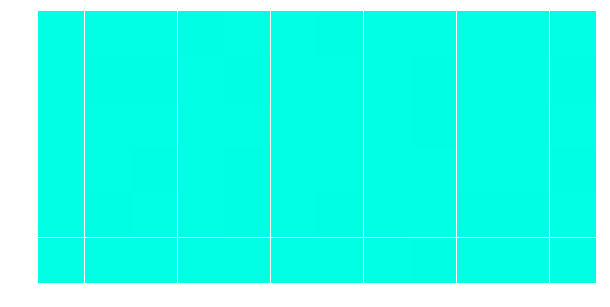

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2523
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2396
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2645
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2709
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2597
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2814
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2968
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2913
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.2971
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3181


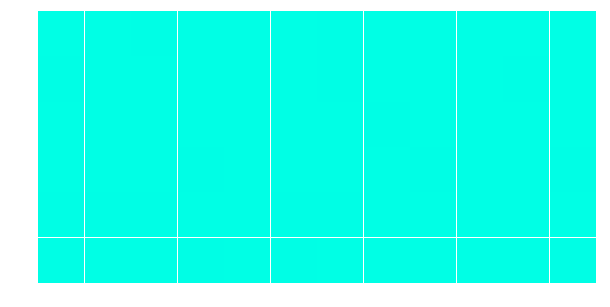

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3133
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3320
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3274
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3350
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.0297
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.3997
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.2478
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.0220
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.0270
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.7620


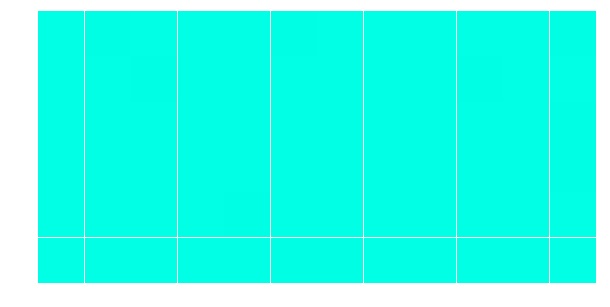

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.2960
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.6667
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.2898
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.9819
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4526
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.4969
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 18.2799
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.5971
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4454
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.9654


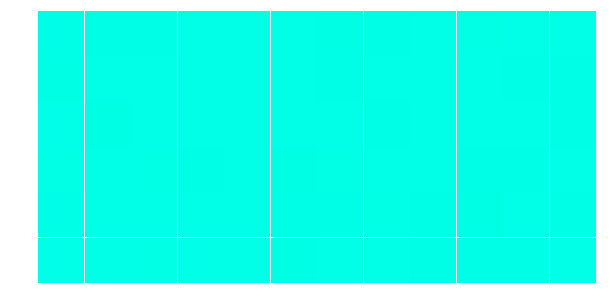

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 16.5969
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4018
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4236
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4082
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4384
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4578
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4467
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4533
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4673
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4548


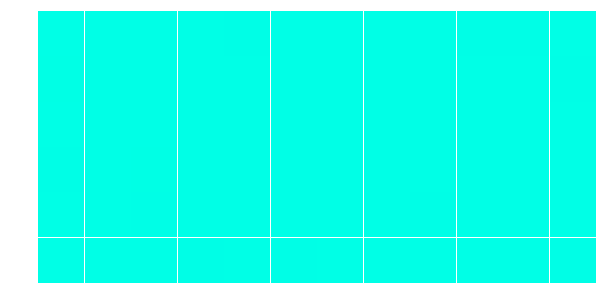

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4688
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4849
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4881
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.4898
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.5098
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.5147
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 15.5005
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5175
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5395
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5323


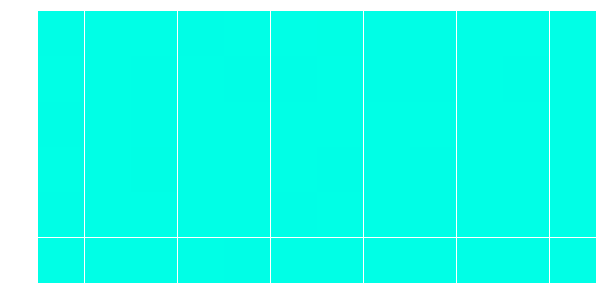

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5505
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5504
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5663
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5655
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5798
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5816
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7966
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.5873
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6005
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6084


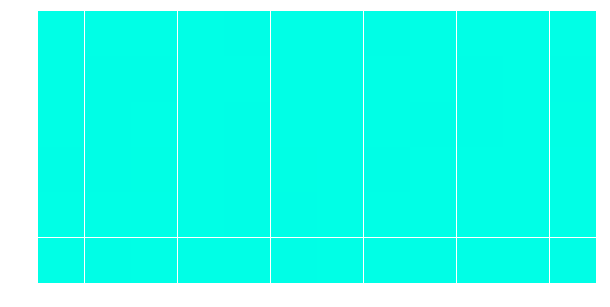

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6125
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6295
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6280
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6418
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6487
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6684
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6522
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6770
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6579
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6754


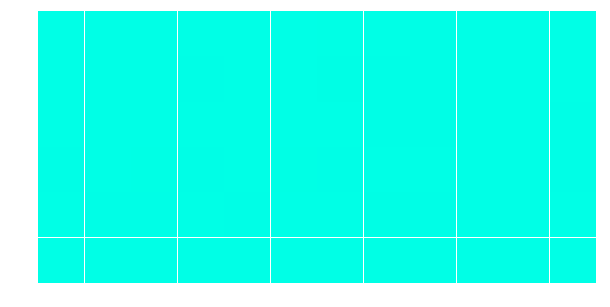

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6804
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6941
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6946
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.6830
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7102
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7236
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7246
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7428
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7372
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7374


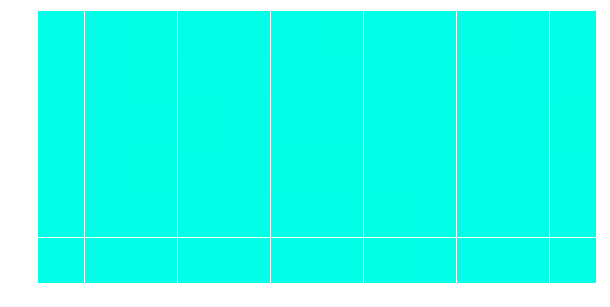

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7683
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7579
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7688
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7730
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7732
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7937
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.7951
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.8093
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.8095
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.8121


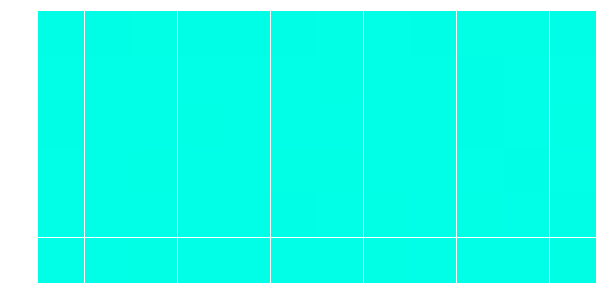

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 20.7260
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.9442
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.8745
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.9287
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 16.8663
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.1435
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.5876
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.9269
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.8167
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 16.6981


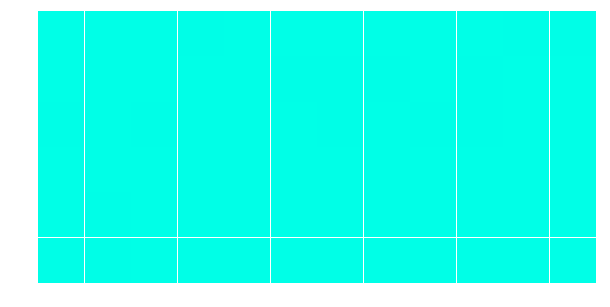

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.9426
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.0944
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 15.9244
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 17.0241
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 16.1420
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.8692
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9494
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1733
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9286
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9152


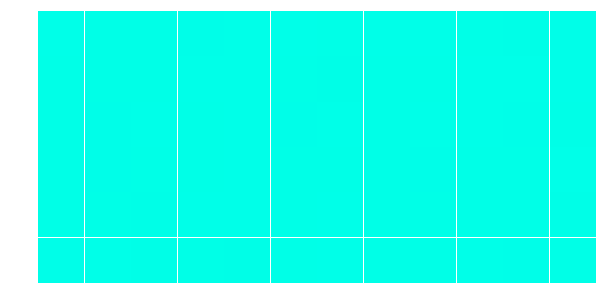

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.7384
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.7719
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 17.8626
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 17.7832
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 17.8980
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.2326
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9375
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9140
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9547
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9328


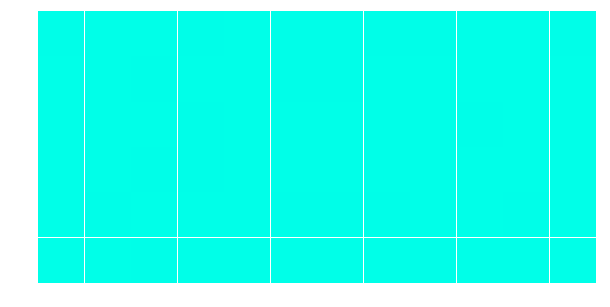

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9468
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9206
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9409
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9703
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9622
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9682
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9883
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 15.9863
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0019
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0170


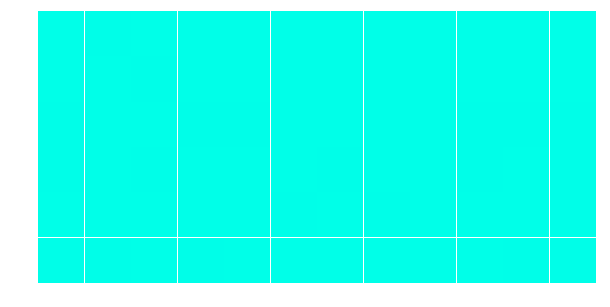

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0145
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0374
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0300
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0511
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0357
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0637
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0586
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0526
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0634
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0807


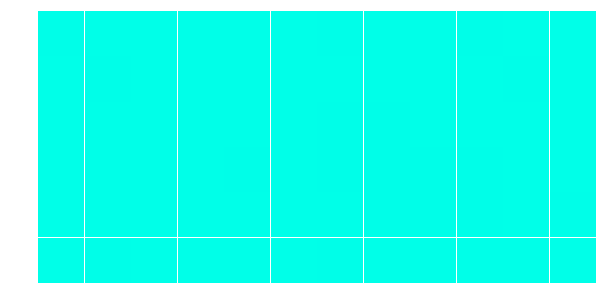

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0784
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0869
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0828
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0999
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.0977
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1129
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1432
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1309
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1367
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1283


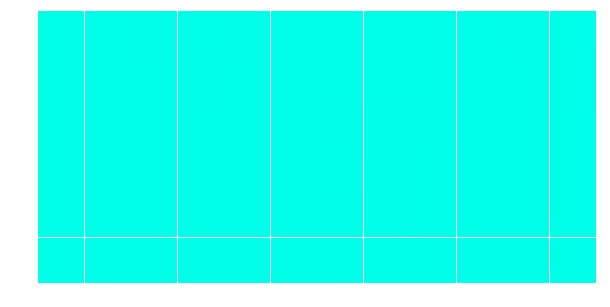

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1484
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1574
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1729
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 20.6304
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.9412
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 17.4252
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 17.0320
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1940
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1864
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1925


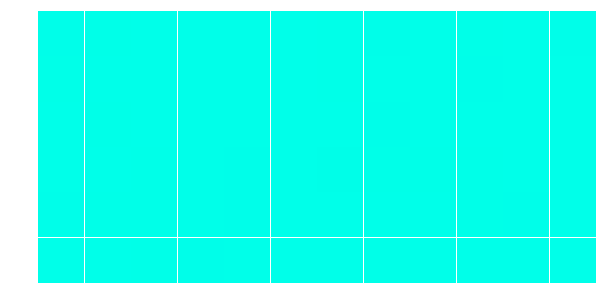

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.1991
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 16.2005


In [34]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

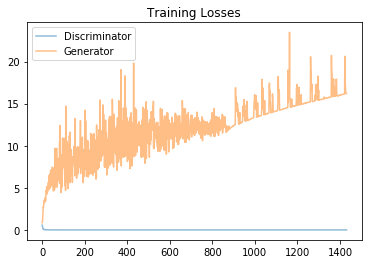

In [35]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

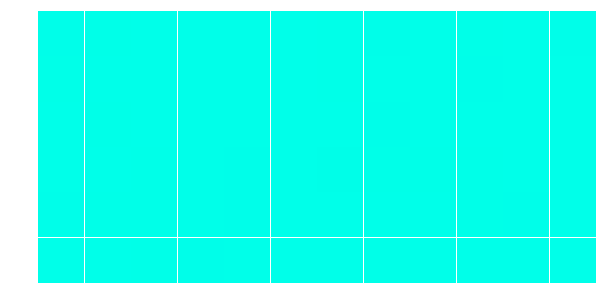

In [36]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))